## Descriptions:
Reads isocontours from multiple timesteps and bins the data by the algebraic value of curvature.
Features are grouped into MI-based clusters, one representative is selected per cluster, then
representatives are ranked within each curvature bin using (1) Joint Mutual Information (JMI)
and (2) Conditional Mutual Information Maximization (CMIM). Selected features from the two methods
are compared per curvature cluster.


In [1]:
from __future__ import annotations
from pathlib import Path
import os
os.chdir("../../..")
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple, Optional
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from flamekit.io_fronts import Case, load_fronts


### Read config file and define helper functions

In [2]:
PROJECT_ROOT = Path.cwd().resolve()
CONFIG_PATH = PROJECT_ROOT / "notebooks" / "case_studies/Feature_selection_mi_cluster_jmi_cmim" / "Feature_selection_mi_cluster_jmi_cmim.yaml"
CFG = yaml.safe_load(CONFIG_PATH.read_text(encoding="utf-8"))

BASE_DIR = PROJECT_ROOT / Path(CFG["BASE_DIR"])
PHI = float(CFG["PHI"])
LAT_SIZE = str(CFG["LAT_SIZE"])
POST = bool(CFG["POST"])

TIME_STEPS = list(CFG["TIME_STEPS"])
ISOLEVEL = float(CFG["ISOLEVEL"])
TARGET_VAR = str(CFG["TARGET_VAR"])
TARGET_LABEL = str(CFG["TARGET_LABEL"])
HIST_BINS = int(CFG["HIST_BINS"])

CLUSTER_ON_SPATIAL = bool(CFG["CLUSTER_ON_SPATIAL"])

CLUSTER_FEATURES_INCLUDE = set(CFG["CLUSTER_FEATURES_INCLUDE"])

MODEL_FEATURES_INCLUDE = set(CFG["MODEL_FEATURES_INCLUDE"])

FEATURES_EXCLUDE = set(CFG.get("FEATURES_EXCLUDE", []))

CURVATURE_COLUMN = str(CFG["CURVATURE_COLUMN"])
CURVATURE_BOUNDS = tuple(CFG["CURVATURE_BOUNDS"])
N_CLUSTERS = len(CURVATURE_BOUNDS) + 1

K_SELECT_PER_CLUSTER = int(CFG["K_SELECT_PER_CLUSTER"])
MIN_CLUSTER_SAMPLES = int(CFG["MIN_CLUSTER_SAMPLES"])
RANDOM_STATE = int(CFG["RANDOM_STATE"])
TEST_SIZE = float(CFG.get("TEST_SIZE", 0.25))

MODEL_PARAMS = dict(CFG.get("MODEL_PARAMS", {"n_estimators": 300, "n_jobs": -1}))
MODEL_PARAMS.setdefault("random_state", RANDOM_STATE)
MODEL_PARAMS.setdefault("n_jobs", -1)


MI_TOPN_PLOT = int(CFG["MI_TOPN_PLOT"])

MI_CLUSTER_THRESHOLD = float(CFG.get("MI_CLUSTER_THRESHOLD", 0.9))
MI_CLUSTER_NORMALIZE = bool(CFG.get("MI_CLUSTER_NORMALIZE", True))

TOPK_REP_PRED = int(CFG.get("TOPK_REP_PRED", 4))


# =========================
# PLOT STYLE (model_verification reference)
# =========================

import matplotlib.pyplot as plt

PLOT_FONT_FAMILY = str(CFG.get("PLOT_FONT_FAMILY", "Courier New"))
PLOT_FONT_SIZE = int(CFG.get("PLOT_FONT_SIZE", 20))
FIG_DPI = int(CFG.get("FIG_DPI", 250))
FIG_SIZE_RAW = CFG.get("FIG_SIZE", (6.8, 6.2))
if isinstance(FIG_SIZE_RAW, (list, tuple)) and len(FIG_SIZE_RAW) == 2:
    FIG_SIZE = (float(FIG_SIZE_RAW[0]), float(FIG_SIZE_RAW[1]))
else:
    FIG_SIZE = (6.8, 6.2)

PLOT_USE_TEX = bool(CFG.get("PLOT_USE_TEX", False))
PLOT_TEX_PREAMBLE_RAW = CFG.get("PLOT_TEX_PREAMBLE", "")
if isinstance(PLOT_TEX_PREAMBLE_RAW, (list, tuple)):
    PLOT_TEX_PREAMBLE = "\n".join(str(item) for item in PLOT_TEX_PREAMBLE_RAW if item)
else:
    PLOT_TEX_PREAMBLE = str(PLOT_TEX_PREAMBLE_RAW) if PLOT_TEX_PREAMBLE_RAW is not None else ""

def apply_plot_style() -> None:
    params = {
        "font.family": PLOT_FONT_FAMILY,
        "font.size": PLOT_FONT_SIZE,
        "axes.titlesize": PLOT_FONT_SIZE,
        "axes.labelsize": PLOT_FONT_SIZE,
        "xtick.labelsize": PLOT_FONT_SIZE,
        "ytick.labelsize": PLOT_FONT_SIZE,
        "legend.fontsize": PLOT_FONT_SIZE,
        "figure.titlesize": PLOT_FONT_SIZE,
        "axes.linewidth": 1.2,
        "text.usetex": PLOT_USE_TEX,
    }
    if PLOT_TEX_PREAMBLE:
        params["text.latex.preamble"] = PLOT_TEX_PREAMBLE
    plt.rcParams.update(params)

apply_plot_style()

COLOR_DATA = str(CFG.get("COLOR_DATA", "#77b5b6"))
COLOR_DATA_EDGE = str(CFG.get("COLOR_DATA_EDGE", "#378d94"))
COLOR_PRED = str(CFG.get("COLOR_PRED", "#9671bd"))
COLOR_PRED_EDGE = str(CFG.get("COLOR_PRED_EDGE", "#6a408d"))
COLOR_NEUTRAL = str(CFG.get("COLOR_NEUTRAL", "#7e7e7e"))
COLOR_LINE = str(CFG.get("COLOR_LINE", "#8a8a8a"))

LABEL_CURV = r"$\kappa^*$"
LABEL_STRETCH = r"$\mathbb{K}^*$"
LABEL_SD = r"$\tilde{S}_d^*$"




ISO_FIG_SIZE = (7.6, 7.6)
SCATTER_S_ISO = 10
ALPHA_ISO = 0.6
LINE_WIDTH = 2.2
PRED_SCATTER_S = 18
PRED_ALPHA = 0.6
LEGEND_KWARGS = dict(
    frameon=False,
    fontsize=PLOT_FONT_SIZE - 2,
    loc="upper center",
    bbox_to_anchor=(0.5, 1.10),
    ncol=2,
    borderaxespad=0.0,
)

def style_axes(ax, *, equal: bool = False) -> None:
    ax.set_axisbelow(True)
    ax.minorticks_on()
    ax.grid(True, which="major", linestyle="-", linewidth=0.75, alpha=0.25)
    ax.grid(True, which="minor", linestyle="-", linewidth=0.25, alpha=0.15)
    ax.tick_params(axis="both", which="both", direction="in", top=True, right=True)
    ax.tick_params(axis="both", which="major", length=6, width=1.0)
    ax.tick_params(axis="both", which="minor", length=3, width=0.8)
    for spine in ax.spines.values():
        spine.set_linewidth(1.2)
    if equal:
        ax.set_aspect("equal", adjustable="box")


def plot_isocontour_scatter(
    df: pd.DataFrame,
    save_stem: str | None = None,
) -> None:
    if "x" not in df.columns or "y" not in df.columns:
        print("[WARN] Missing x/y for isocontour scatter; skipping.")
        return
    fig, ax = plt.subplots(figsize=ISO_FIG_SIZE, dpi=FIG_DPI, constrained_layout=True)
    if "cluster" in df.columns:
        cmap, norm, boundaries = _cluster_cmap_and_norm(N_CLUSTERS)
        sc = ax.scatter(
            df["y"],
            df["x"],
            c=df["cluster"].astype(int),
            s=SCATTER_S_ISO,
            alpha=ALPHA_ISO,
            cmap=cmap,
            norm=norm,
            edgecolors="none",
            zorder=3,
        )
        cbar = fig.colorbar(
            sc,
            ax=ax,
            fraction=0.046,
            pad=0.03,
            ticks=np.arange(N_CLUSTERS),
            boundaries=boundaries,
            spacing="proportional",
        )
        cbar.set_label("Cluster ID")
        cbar.ax.set_yticklabels([str(i) for i in range(N_CLUSTERS)])
    else:
        ax.scatter(
            df["y"],
            df["x"],
            s=SCATTER_S_ISO,
            alpha=ALPHA_ISO,
            color=COLOR_DATA,
            edgecolors=COLOR_DATA_EDGE,
            linewidths=0.6,
            zorder=3,
        )
    ax.set_xlabel("y")
    ax.set_ylabel("x")
    style_axes(ax, equal=True)
    if save_stem is not None:
        save_png(save_stem)
    plt.show()
    plt.close(fig)





# =========================
# PLOT SAVING 
# =========================

OUTPUT_BASE_DIR = PROJECT_ROOT / Path(CFG["OUTPUT_BASE_DIR"])

PHI_TAG = f"phi_{PHI:g}"
LAT_TAG = f"h400x{LAT_SIZE}_ref"


def _time_steps_tag(time_steps: list[int]) -> str:
    if not time_steps:
        return "t_none"
    if len(time_steps) == 1:
        return f"t_{time_steps[0]}"
    t_min = min(time_steps)
    t_max = max(time_steps)
    return f"t_{t_min}_to_{t_max}"

RUN_DIR = OUTPUT_BASE_DIR / PHI_TAG / LAT_TAG / _time_steps_tag(TIME_STEPS)
SAVE_DIR = RUN_DIR
SAVE_DIR.mkdir(parents=True, exist_ok=True)

FIG_DPI = int(CFG["FIG_DPI"])

def _safe_name(s: str) -> str:
    return "".join(ch if (ch.isalnum() or ch in "._-") else "_" for ch in s)

def save_png(stem: str, dpi: int = FIG_DPI):
    """Save current matplotlib figure as PNG/PDF to SAVE_DIR."""
    fname = SAVE_DIR / f"{_safe_name(stem)}.png"
    plt.gcf().savefig(fname, dpi=dpi, bbox_inches="tight", facecolor="white")
    plt.gcf().savefig(fname.with_suffix(".pdf"), bbox_inches="tight")

def save_then_show(stem: str, dpi: int = FIG_DPI):
    save_png(stem, dpi=dpi)
    plt.show()

SAVE_PRED_PLOTS = True

def plot_pred_vs_true(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    title: Optional[str] = None,
    save_stem: Optional[str] = None,
) -> None:
    fig, ax = plt.subplots(figsize=FIG_SIZE, dpi=FIG_DPI, constrained_layout=True)
    ax.scatter(
        y_true,
        y_pred,
        s=PRED_SCATTER_S,
        alpha=PRED_ALPHA,
        color=COLOR_DATA,
        edgecolors=COLOR_DATA_EDGE,
        linewidths=0.5,
        label="Data",
    )
    lim_min = float(min(y_true.min(), y_pred.min()))
    lim_max = float(max(y_true.max(), y_pred.max()))
    ax.plot(
        [lim_min, lim_max],
        [lim_min, lim_max],
        linestyle="--",
        color=COLOR_LINE,
        linewidth=LINE_WIDTH,
        label="1:1",
    )
    ax.set_xlabel(f"{LABEL_SD} (true)")
    ax.set_ylabel(f"{LABEL_SD} (pred)")
    ax.legend(**LEGEND_KWARGS)
    style_axes(ax, equal=True)
    if SAVE_PRED_PLOTS and save_stem:
        save_png(save_stem, dpi=FIG_DPI)
    plt.show()
    plt.close(fig)


print(f"[INFO] Saving plots to: {SAVE_DIR}")


# =========================
# Utilities
# =========================

def _numeric_cols(df: pd.DataFrame) -> List[str]:
    return [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]

def resolve_features(
    df: pd.DataFrame,
    include: Optional[List[str] | set[str]],
    exclude: set[str],
) -> List[str]:
    num = set(_numeric_cols(df))
    feats = num if include is None else set(include).intersection(num)
    feats = feats.difference(exclude)
    return sorted(feats)

def intersect_feature_space(feature_sets: List[set[str]]) -> List[str]:
    if not feature_sets:
        return []
    common = set.intersection(*feature_sets)
    return sorted(common)

def _cluster_cmap_and_norm(n_clusters: int):
    """
    Nice, visible, colorblind-friendly discrete colors.
    - For small k: use Set2 (pleasant + distinct)
    - For larger: fall back to tab10/tab20
    """
    from matplotlib.colors import ListedColormap, BoundaryNorm

    base_colors = [
        COLOR_DATA,
        COLOR_NEUTRAL,
        COLOR_PRED,
        COLOR_DATA_EDGE,
        COLOR_PRED_EDGE,
        COLOR_LINE,
    ]

    if n_clusters <= len(base_colors):
        colors = base_colors[:n_clusters]
    else:
        base = plt.get_cmap("tab20")
        colors = [base(i) for i in range(n_clusters)]

    cmap = ListedColormap(colors)
    boundaries = np.arange(-0.5, n_clusters + 0.5, 1.0)
    norm = BoundaryNorm(boundaries, ncolors=n_clusters)
    return cmap, norm, boundaries

def labeled_cluster_plot_xy(dfc: pd.DataFrame, n_clusters: int, title: str):
    """
    XY plot with discrete colors and a discrete colorbar (exactly n_clusters).
    Titles removed.
    """
    if "x" not in dfc.columns or "y" not in dfc.columns:
        return

    cmap, norm, boundaries = _cluster_cmap_and_norm(n_clusters)

    fig, ax = plt.subplots(figsize=ISO_FIG_SIZE, dpi=FIG_DPI, constrained_layout=True)
    sc = ax.scatter(
        dfc["y"], dfc["x"],
        c=dfc["cluster"].astype(int),
        s=3,
        cmap=cmap,
        norm=norm,
        edgecolors="none",
    )

    ax.set_xlabel("y")
    ax.set_ylabel("x")
    style_axes(ax, equal=True)

    cbar = fig.colorbar(
        sc,
        ticks=np.arange(n_clusters),
        boundaries=boundaries,
        spacing="proportional",
    )
    cbar.set_label("Cluster ID")
    cbar.ax.set_yticklabels([str(i) for i in range(n_clusters)])
    save_then_show(f"clusters_xy_iso{ISOLEVEL}_ts{int(dfc['timestep'].iloc[0])}_k{n_clusters}")


def _cluster_color(cluster_id: int, n_clusters: int):
    cmap, _, _ = _cluster_cmap_and_norm(n_clusters)
    if hasattr(cmap, "colors") and cluster_id < len(cmap.colors):
        return cmap.colors[cluster_id]
    denom = max(n_clusters - 1, 1)
    return cmap(cluster_id / denom)


def plot_curvature_distribution(
    sub: pd.DataFrame,
    cluster_id: int,
    curvature_col: str,
    bins: int,
    n_clusters: int,
):
    if curvature_col not in sub.columns or len(sub) == 0:
        return
    color = _cluster_color(cluster_id, n_clusters)
    fig, ax = plt.subplots(figsize=(6, 4), dpi=FIG_DPI, constrained_layout=True)
    ax.hist(sub[curvature_col].to_numpy(), bins=bins, color=color, alpha=0.85)
    ax.set_xlabel(curvature_col)
    ax.set_ylabel("Count")
    style_axes(ax)
    save_then_show(
        f"curvature_dist_iso{ISOLEVEL}_ts{'-'.join(map(str, TIME_STEPS))}_cluster{cluster_id}_n{len(sub)}"
    )


def plot_target_distribution(
    sub: pd.DataFrame,
    cluster_id: int,
    target_var: str,
    target_label: str,
    bins: int,
    n_clusters: int,
):
    if target_var not in sub.columns or len(sub) == 0:
        return
    color = _cluster_color(cluster_id, n_clusters)
    fig, ax = plt.subplots(figsize=(6, 4), dpi=FIG_DPI, constrained_layout=True)
    ax.hist(sub[target_var].to_numpy(), bins=bins, color=color, alpha=0.85)
    ax.set_xlabel(target_label)
    ax.set_ylabel("Count")
    style_axes(ax)
    save_then_show(
        f"{target_label}_dist_iso{ISOLEVEL}_ts{'-'.join(map(str, TIME_STEPS))}_cluster{cluster_id}_n{len(sub)}"
    )


def mrmr_greedy(
    X: np.ndarray,
    y: np.ndarray,
    feature_cols: List[str],
    k_select: int,
    random_state: int = 0,
) -> Tuple[List[str], pd.Series]:
    """
    Greedy mRMR: score(j) = I(Xj; y) - mean_{s in selected} I(Xj; Xs)
    """
    n_samples, n_features = X.shape
    if n_features == 0:
        return [], pd.Series(dtype=float)

    k_select = int(min(k_select, n_features))

    mi_ft = mutual_info_regression(X, y, random_state=random_state)
    mi_rank = pd.Series(mi_ft, index=feature_cols).sort_values(ascending=False)

    # redundancy MI matrix
    mi_ff = np.zeros((n_features, n_features), dtype=float)
    for i in range(n_features):
        Xi = X[:, [i]]
        for j in range(i + 1, n_features):
            Xj = X[:, j]
            mi_ij = mutual_info_regression(Xi, Xj, random_state=random_state)[0]
            mi_ff[i, j] = mi_ij
            mi_ff[j, i] = mi_ij

    selected_idx: List[int] = []
    selected_feats: List[str] = []

    for _ in range(k_select):
        best_score = -np.inf
        best_j: Optional[int] = None

        for j in range(n_features):
            if j in selected_idx:
                continue
            relevance = mi_ft[j]
            redundancy = 0.0 if len(selected_idx) == 0 else float(np.mean([mi_ff[j, s] for s in selected_idx]))
            score = relevance - redundancy

            if score > best_score:
                best_score = score
                best_j = j

        if best_j is None:
            break

        selected_idx.append(best_j)
        selected_feats.append(feature_cols[best_j])

    return selected_feats, mi_rank

def plot_feature_correlation(
    df: pd.DataFrame,
    features: List[str],
    stem: str,
):
    if not features:
        print("[WARN] No features provided for correlation plot.")
        return

    corr = df[features].corr()

    fig, ax = plt.subplots(
        figsize=(0.35 * len(features) + 3, 0.35 * len(features) + 2),
        dpi=FIG_DPI,
        constrained_layout=True,
    )
    im = ax.imshow(corr.to_numpy(), vmin=-1, vmax=1, cmap="coolwarm")
    ax.set_xticks(np.arange(len(features)))
    ax.set_xticklabels(features, rotation=90)
    ax.set_yticks(np.arange(len(features)))
    ax.set_yticklabels(features)
    fig.colorbar(im, label="Pearson r")
    style_axes(ax)
    ax.grid(False)
    save_then_show(stem)

    print(f"[INFO] Correlation plot saved: {stem}")




def compute_feature_mi_matrix(
    df: pd.DataFrame,
    features: List[str],
    random_state: int = RANDOM_STATE,
) -> pd.DataFrame:
    if not features:
        return pd.DataFrame()

    data = df[features].dropna()
    if data.empty:
        print("[WARN] No non-NaN rows available for MI matrix.")
        return pd.DataFrame(index=features, columns=features, dtype=float)

    X = data.to_numpy()
    n_features = len(features)
    mi_mat = np.zeros((n_features, n_features), dtype=float)

    for i in range(n_features):
        Xi = X[:, [i]]
        for j in range(i + 1, n_features):
            mi_ij = mutual_info_regression(Xi, X[:, j], random_state=random_state)[0]
            mi_mat[i, j] = mi_ij
            mi_mat[j, i] = mi_ij

    return pd.DataFrame(mi_mat, index=features, columns=features)


def plot_feature_mi_table(
    df: pd.DataFrame,
    features: List[str],
    stem: str,
    random_state: int = RANDOM_STATE,
    normalize: bool = False,
) -> pd.DataFrame:
    if not features:
        print("[WARN] No features provided for MI plot.")
        return pd.DataFrame()

    mi_table = compute_feature_mi_matrix(df, features, random_state=random_state)
    if mi_table.empty:
        return mi_table

    vmax = float(np.nanmax(mi_table.to_numpy()))
    if vmax <= 0:
        vmax = 1.0
    cbar_label = "Mutual information"

    fig, ax = plt.subplots(
        figsize=(0.35 * len(features) + 3, 0.35 * len(features) + 2),
        dpi=FIG_DPI,
        constrained_layout=True,
    )
    im = ax.imshow(mi_table.to_numpy(), vmin=0, vmax=vmax, cmap="viridis")
    ax.set_xticks(np.arange(len(features)))
    ax.set_yticks(np.arange(len(features)))
    ax.set_xticklabels([_latexify_feature(f) for f in features], fontsize=PLOT_FONT_SIZE - 6, rotation = 60)
    ax.set_yticklabels([_latexify_feature(f) for f in features], fontsize=PLOT_FONT_SIZE - 6, rotation = 0)
    fig.colorbar(im, label=cbar_label)
    try:
        engine = fig.get_layout_engine()
    except Exception:
        engine = None
    if engine is None:
        fig.tight_layout()
    style_axes(ax)
    ax.grid(False)
    save_then_show(stem)

    print(f"[INFO] MI plot saved: {stem}")
    return mi_table
def mi_feature_clusters(
    mi: pd.DataFrame,
    threshold: float,
    normalize: bool = False,
    linkage: str = "average",
) -> List[List[str]]:
    if mi.empty:
        return []

    mat = mi.to_numpy().copy().astype(float)
    mat = np.nan_to_num(mat, nan=0.0)

    max_val = float(np.max(mat)) if mat.size else 0.0
    if max_val <= 0:
        return [[name] for name in mi.columns]

    np.fill_diagonal(mat, max_val)
    dist = max_val - mat
    np.fill_diagonal(dist, 0.0)

    dist_threshold = max(0.0, min(max_val, max_val - float(threshold)))
    names = list(mi.columns)

    try:
        from scipy.cluster.hierarchy import linkage as hlinkage, fcluster
        from scipy.spatial.distance import squareform
        condensed = squareform(dist, checks=False)
        Z = hlinkage(condensed, method=linkage)
        labels = fcluster(Z, t=dist_threshold, criterion="distance")
    except ImportError:
        print("[WARN] scipy not available; falling back to sklearn AgglomerativeClustering.")
        try:
            model = AgglomerativeClustering(
                n_clusters=None,
                linkage=linkage,
                metric="precomputed",
                distance_threshold=dist_threshold,
            )
        except TypeError:
            model = AgglomerativeClustering(
                n_clusters=None,
                linkage=linkage,
                affinity="precomputed",
                distance_threshold=dist_threshold,
            )
        labels = model.fit_predict(dist)

    clusters: List[List[str]] = []
    for label in sorted(set(labels)):
        feats = [names[i] for i in range(len(names)) if labels[i] == label]
        clusters.append(sorted(feats))

    return clusters
def select_representative_features(
    df: pd.DataFrame,
    clusters: List[List[str]],
    target_var: str,
    random_state: int = RANDOM_STATE,
) -> Tuple[List[str], pd.DataFrame, pd.Series]:
    if not clusters:
        return [], pd.DataFrame(), pd.Series(dtype=float)

    features = sorted({f for cluster in clusters for f in cluster})
    data = df[features + [target_var]].dropna()
    if data.empty:
        print("[WARN] No non-NaN rows available for representative MI.")
        return [], pd.DataFrame(), pd.Series(dtype=float)

    mi_vals = mutual_info_regression(
        data[features].to_numpy(),
        data[target_var].to_numpy(),
        random_state=random_state,
    )
    mi_series = pd.Series(mi_vals, index=features)

    rep_rows = []
    reps: List[str] = []
    for cl_id, cluster_feats in enumerate(clusters):
        avail = [f for f in cluster_feats if f in mi_series.index]
        if not avail:
            continue
        best = mi_series.loc[avail].idxmax()
        reps.append(best)
        rep_rows.append({
            "mi_cluster": cl_id,
            "n_features": int(len(cluster_feats)),
            "representative": best,
            "mi_target": float(mi_series.loc[best]),
            "features": ", ".join(cluster_feats),
        })

    rep_df = pd.DataFrame(rep_rows)
    return reps, rep_df, mi_series



def _residualize(target: np.ndarray, cond: np.ndarray) -> np.ndarray:
    if cond.size == 0:
        return target
    X = np.column_stack([np.ones(len(target)), cond])
    coef, _, _, _ = np.linalg.lstsq(X, target, rcond=None)
    return target - X @ coef


# Approximate conditional MI by residualizing on the conditioning set.
def conditional_mi_residuals(
    target: np.ndarray,
    feature: np.ndarray,
    cond: np.ndarray,
    random_state: int = RANDOM_STATE,
) -> float:
    y_res = _residualize(target, cond)
    x_res = _residualize(feature, cond)
    mi_val = mutual_info_regression(x_res.reshape(-1, 1), y_res, random_state=random_state)[0]
    return float(mi_val)


def conditional_mi_rank(
    df: pd.DataFrame,
    target_var: str,
    features: List[str],
    cond_features: List[str],
    random_state: int = RANDOM_STATE,
) -> pd.Series:
    if not features:
        return pd.Series(dtype=float)
    cols = list(features) + list(cond_features) + [target_var]
    data = df[cols].dropna()
    if data.empty:
        return pd.Series(dtype=float)

    y = data[target_var].to_numpy()
    cond = data[cond_features].to_numpy() if cond_features else np.empty((len(data), 0))

    scores = {}
    for f in features:
        x = data[f].to_numpy()
        scores[f] = conditional_mi_residuals(y, x, cond, random_state=random_state)

    return pd.Series(scores).sort_values(ascending=False)


def select_conditional_mi_features(
    df: pd.DataFrame,
    target_var: str,
    features: List[str],
    k_select: int,
    random_state: int = RANDOM_STATE,
) -> tuple[list[str], dict[int, pd.Series], pd.Series]:
    selected: List[str] = []
    remaining = list(features)
    history: Dict[int, pd.Series] = {}

    for step in range(min(k_select, len(remaining))):
        rank = conditional_mi_rank(
            df=df,
            target_var=target_var,
            features=remaining,
            cond_features=selected,
            random_state=random_state,
        )
        if rank.empty:
            break
        history[step + 1] = rank
        best = rank.index[0]
        selected.append(best)
        remaining.remove(best)

    remaining_rank = conditional_mi_rank(
        df=df,
        target_var=target_var,
        features=remaining,
        cond_features=selected,
        random_state=random_state,
    )

    return selected, history, remaining_rank



# JMI/CMIM approximated via residualized conditional MI.
def select_jmi_features(
    df: pd.DataFrame,
    target_var: str,
    features: List[str],
    k_select: int,
    random_state: int = RANDOM_STATE,
) -> tuple[list[str], dict[int, pd.Series]]:
    if not features:
        return [], {}

    data = df[features + [target_var]].dropna()
    if data.empty:
        return [], {}

    y = data[target_var].to_numpy()
    X = data[features].to_numpy()
    base_mi = mutual_info_regression(X, y, random_state=random_state)
    base_series = pd.Series(base_mi, index=features)

    selected: List[str] = []
    remaining = list(features)
    history: Dict[int, pd.Series] = {}

    for step in range(min(k_select, len(remaining))):
        if not selected:
            rank = base_series.loc[remaining].sort_values(ascending=False)
        else:
            scores = {}
            cond_matrix = data[selected].to_numpy()
            for f in remaining:
                x = data[f].to_numpy()
                cond_scores = []
                for i in range(cond_matrix.shape[1]):
                    s_col = cond_matrix[:, [i]]
                    cond_scores.append(conditional_mi_residuals(y, x, s_col, random_state=random_state))
                scores[f] = float(base_series.loc[f] + np.mean(cond_scores))
            rank = pd.Series(scores).sort_values(ascending=False)

        history[step + 1] = rank
        best = rank.index[0]
        selected.append(best)
        remaining.remove(best)

    return selected, history



def select_cmim_features(
    df: pd.DataFrame,
    target_var: str,
    features: List[str],
    k_select: int,
    random_state: int = RANDOM_STATE,
) -> tuple[list[str], dict[int, pd.Series]]:
    if not features:
        return [], {}

    data = df[features + [target_var]].dropna()
    if data.empty:
        return [], {}

    y = data[target_var].to_numpy()
    X = data[features].to_numpy()
    base_mi = mutual_info_regression(X, y, random_state=random_state)
    base_series = pd.Series(base_mi, index=features)

    selected: List[str] = []
    remaining = list(features)
    history: Dict[int, pd.Series] = {}

    for step in range(min(k_select, len(remaining))):
        if not selected:
            rank = base_series.loc[remaining].sort_values(ascending=False)
        else:
            scores = {}
            cond_matrix = data[selected].to_numpy()
            for f in remaining:
                x = data[f].to_numpy()
                cond_scores = []
                for i in range(cond_matrix.shape[1]):
                    s_col = cond_matrix[:, [i]]
                    cond_scores.append(conditional_mi_residuals(y, x, s_col, random_state=random_state))
                scores[f] = float(np.min(cond_scores)) if cond_scores else float(base_series.loc[f])
            rank = pd.Series(scores).sort_values(ascending=False)

        history[step + 1] = rank
        best = rank.index[0]
        selected.append(best)
        remaining.remove(best)

    return selected, history


[INFO] Saving plots to: /media/alexandros/OS/Users/alexp/Documents/Bachelor Thesis/Code/report_figures/results/mi_cluster_jmi_cmim/lat_200/t_200_to_220/h_200_t_200_210_220_iso_0.6


### Load data

In [2]:
dfs = []
cluster_feature_sets_per_t: List[set[str]] = []
model_feature_sets_per_t: List[set[str]] = []

cluster_include = set(CLUSTER_FEATURES_INCLUDE)
if CLUSTER_ON_SPATIAL:
    cluster_include = cluster_include.union({"x", "y", "z"})

model_include = set(MODEL_FEATURES_INCLUDE)

for ts in TIME_STEPS:
    CASE = Case(
        base_dir=BASE_DIR,
        phi=PHI,
        lat_size=LAT_SIZE,
        time_step=ts,
        post=POST,
    )

    fronts = load_fronts(CASE, [ISOLEVEL])
    if ISOLEVEL not in fronts:
        raise ValueError(f"ISOLEVEL {ISOLEVEL} not found for timestep {ts}")

    df_t = fronts[ISOLEVEL].copy()
    df_t["c_iso"] = float(ISOLEVEL)
    df_t["timestep"] = int(ts)

    if TARGET_VAR not in df_t.columns:
        raise ValueError(f"TARGET_VAR '{TARGET_VAR}' not found for timestep {ts}")

    cl_feats_t = set(resolve_features(df_t, cluster_include, FEATURES_EXCLUDE))
    ml_feats_t = set(resolve_features(df_t, model_include, FEATURES_EXCLUDE))

    cluster_feature_sets_per_t.append(cl_feats_t)
    model_feature_sets_per_t.append(ml_feats_t)

    dfs.append(df_t)

df_all = pd.concat(dfs, ignore_index=True)
print(f"Pooled rows total: n={len(df_all)} across timesteps={TIME_STEPS}")

cluster_features = intersect_feature_space(cluster_feature_sets_per_t)
model_features = intersect_feature_space(model_feature_sets_per_t)

if len(cluster_features) == 0:
    raise ValueError("No common numeric CLUSTER features across requested timesteps. Adjust CLUSTER_FEATURES_INCLUDE.")
if len(model_features) == 0:
    raise ValueError("No common numeric MODEL features across requested timesteps. Adjust MODEL_FEATURES_INCLUDE.")

print(f"\nCluster features (common across all timesteps): {cluster_features}")
print(f"Model features (common across all timesteps):   {model_features}")

required = sorted(set(cluster_features).union(model_features).union({TARGET_VAR, CURVATURE_COLUMN}))
dfc = df_all.dropna(subset=required).copy()
print(f"\nAfter dropna on required (cluster+model+target): n={len(dfc)}")

# --- Curvature histogram across all data ---
if CURVATURE_COLUMN in dfc.columns and len(dfc) > 0:
    fig, ax = plt.subplots(figsize=(6, 4), dpi=FIG_DPI, constrained_layout=True)
    ax.hist(dfc[CURVATURE_COLUMN].to_numpy(), bins=HIST_BINS, color=COLOR_DATA, alpha=0.85)
    ax.set_xlabel(CURVATURE_COLUMN)
    ax.set_ylabel("Count")
    style_axes(ax)
    save_then_show(
        f"curvature_dist_iso{ISOLEVEL}_ts{'-'.join(map(str, TIME_STEPS))}_all_n{len(dfc)}"
    )


NameError: name 'List' is not defined

### Feature MI clustering + representative selection (global)

In [1]:
plot_feature_correlation(
    df=dfc,
    features=list(model_features),
    stem=f"feature_corr_iso{ISOLEVEL}_ts{'-'.join(map(str, TIME_STEPS))}",
)

mi_table = plot_feature_mi_table(
    df=dfc,
    features=list(model_features),
    stem=f"feature_mi_iso{ISOLEVEL}_ts{'-'.join(map(str, TIME_STEPS))}",
)
mi_table

mi_clusters: List[List[str]] = []
if mi_table.empty:
    print("[WARN] MI table empty; skipping MI clustering.")
else:
    mi_clusters = mi_feature_clusters(
        mi=mi_table,
        threshold=MI_CLUSTER_THRESHOLD,
        normalize=MI_CLUSTER_NORMALIZE,
    )

rep_features, rep_info_df, global_mi = select_representative_features(
    df=dfc,
    clusters=mi_clusters,
    target_var=TARGET_VAR,
    random_state=RANDOM_STATE,
)

cluster_map_rows = []
for cl_id, feats in enumerate(mi_clusters):
    for f in feats:
        cluster_map_rows.append({"mi_cluster": cl_id, "feature": f})

cluster_map_df = pd.DataFrame(cluster_map_rows)

if cluster_map_df.empty:
    print("[WARN] No MI clusters found.")
else:
    cluster_map_csv = SAVE_DIR / "mi_feature_clusters.csv"
    cluster_map_df.to_csv(cluster_map_csv, index=False)
    print(f"[INFO] Wrote MI cluster map: {cluster_map_csv}")

if rep_info_df.empty:
    print("[WARN] No representatives selected.")
else:
    rep_csv = SAVE_DIR / "mi_cluster_representatives.csv"
    rep_info_df.to_csv(rep_csv, index=False)
    print(f"[INFO] Wrote representative summary: {rep_csv}")
    print(f"Representatives ({len(rep_features)}): {rep_features}")


rep_info_df


NameError: name 'plot_feature_correlation' is not defined

### Curvature Binning


Curvature bins: (-0.1, 0.1) -> clusters 0..2


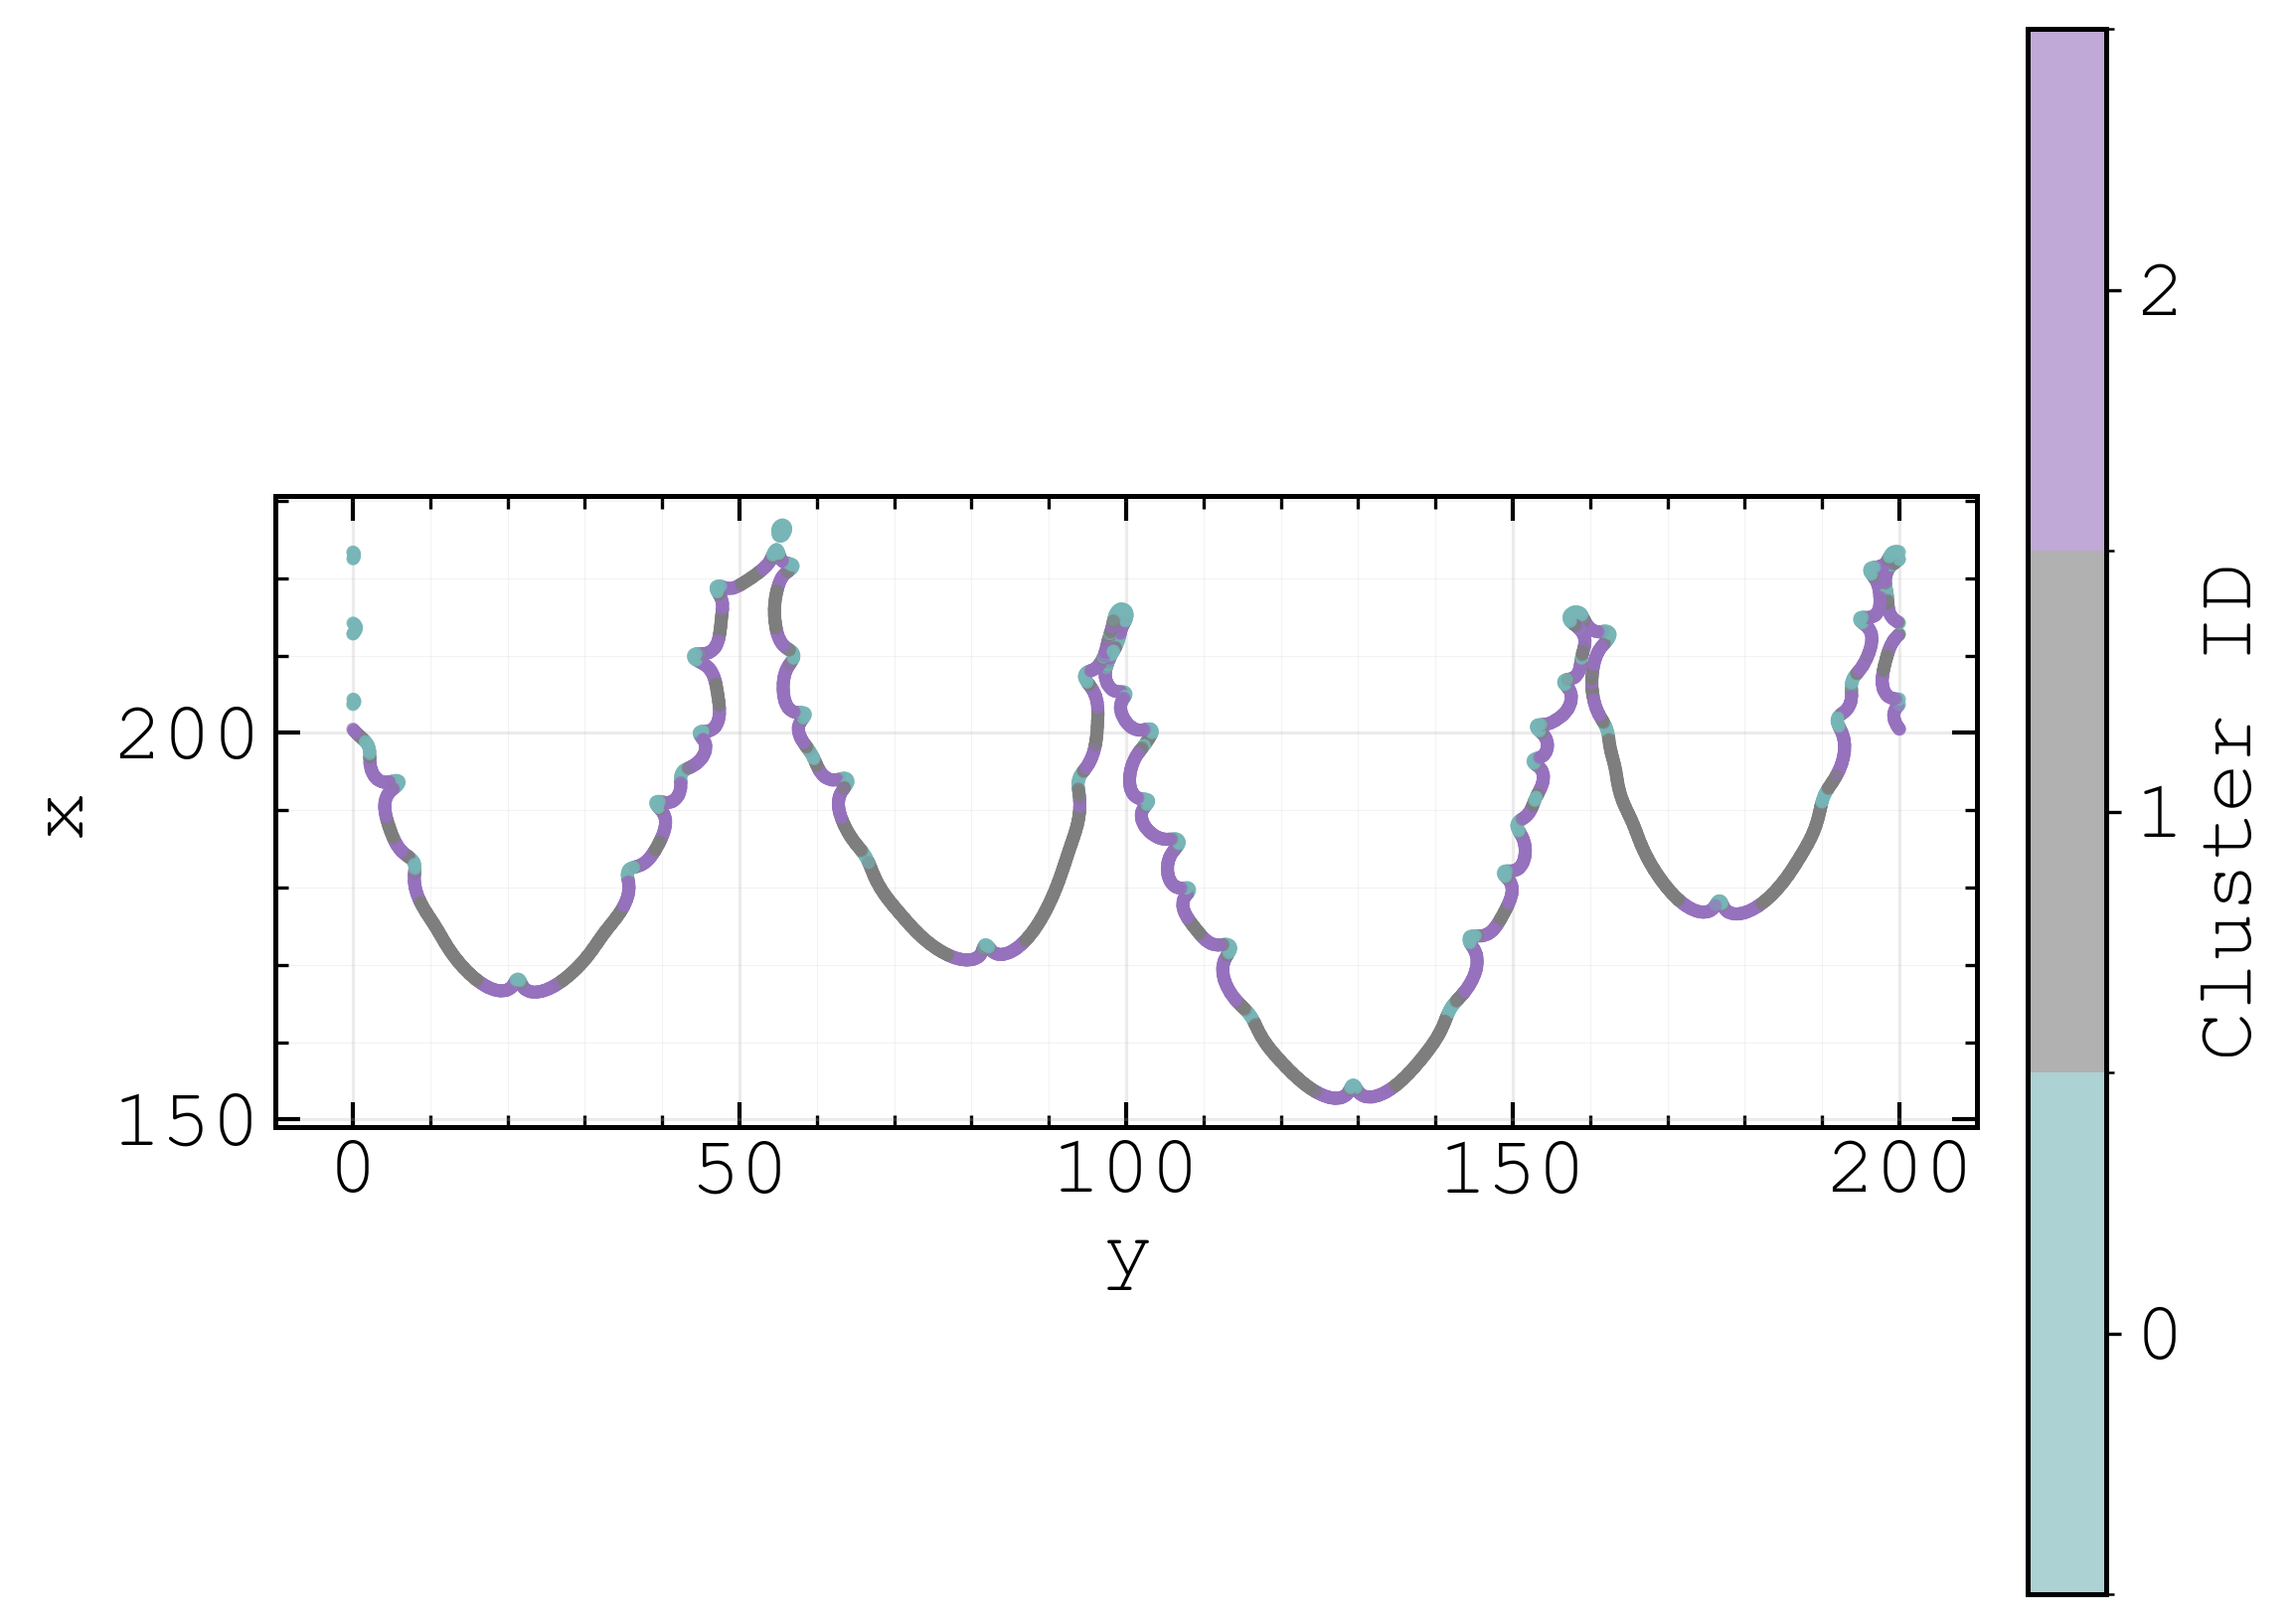

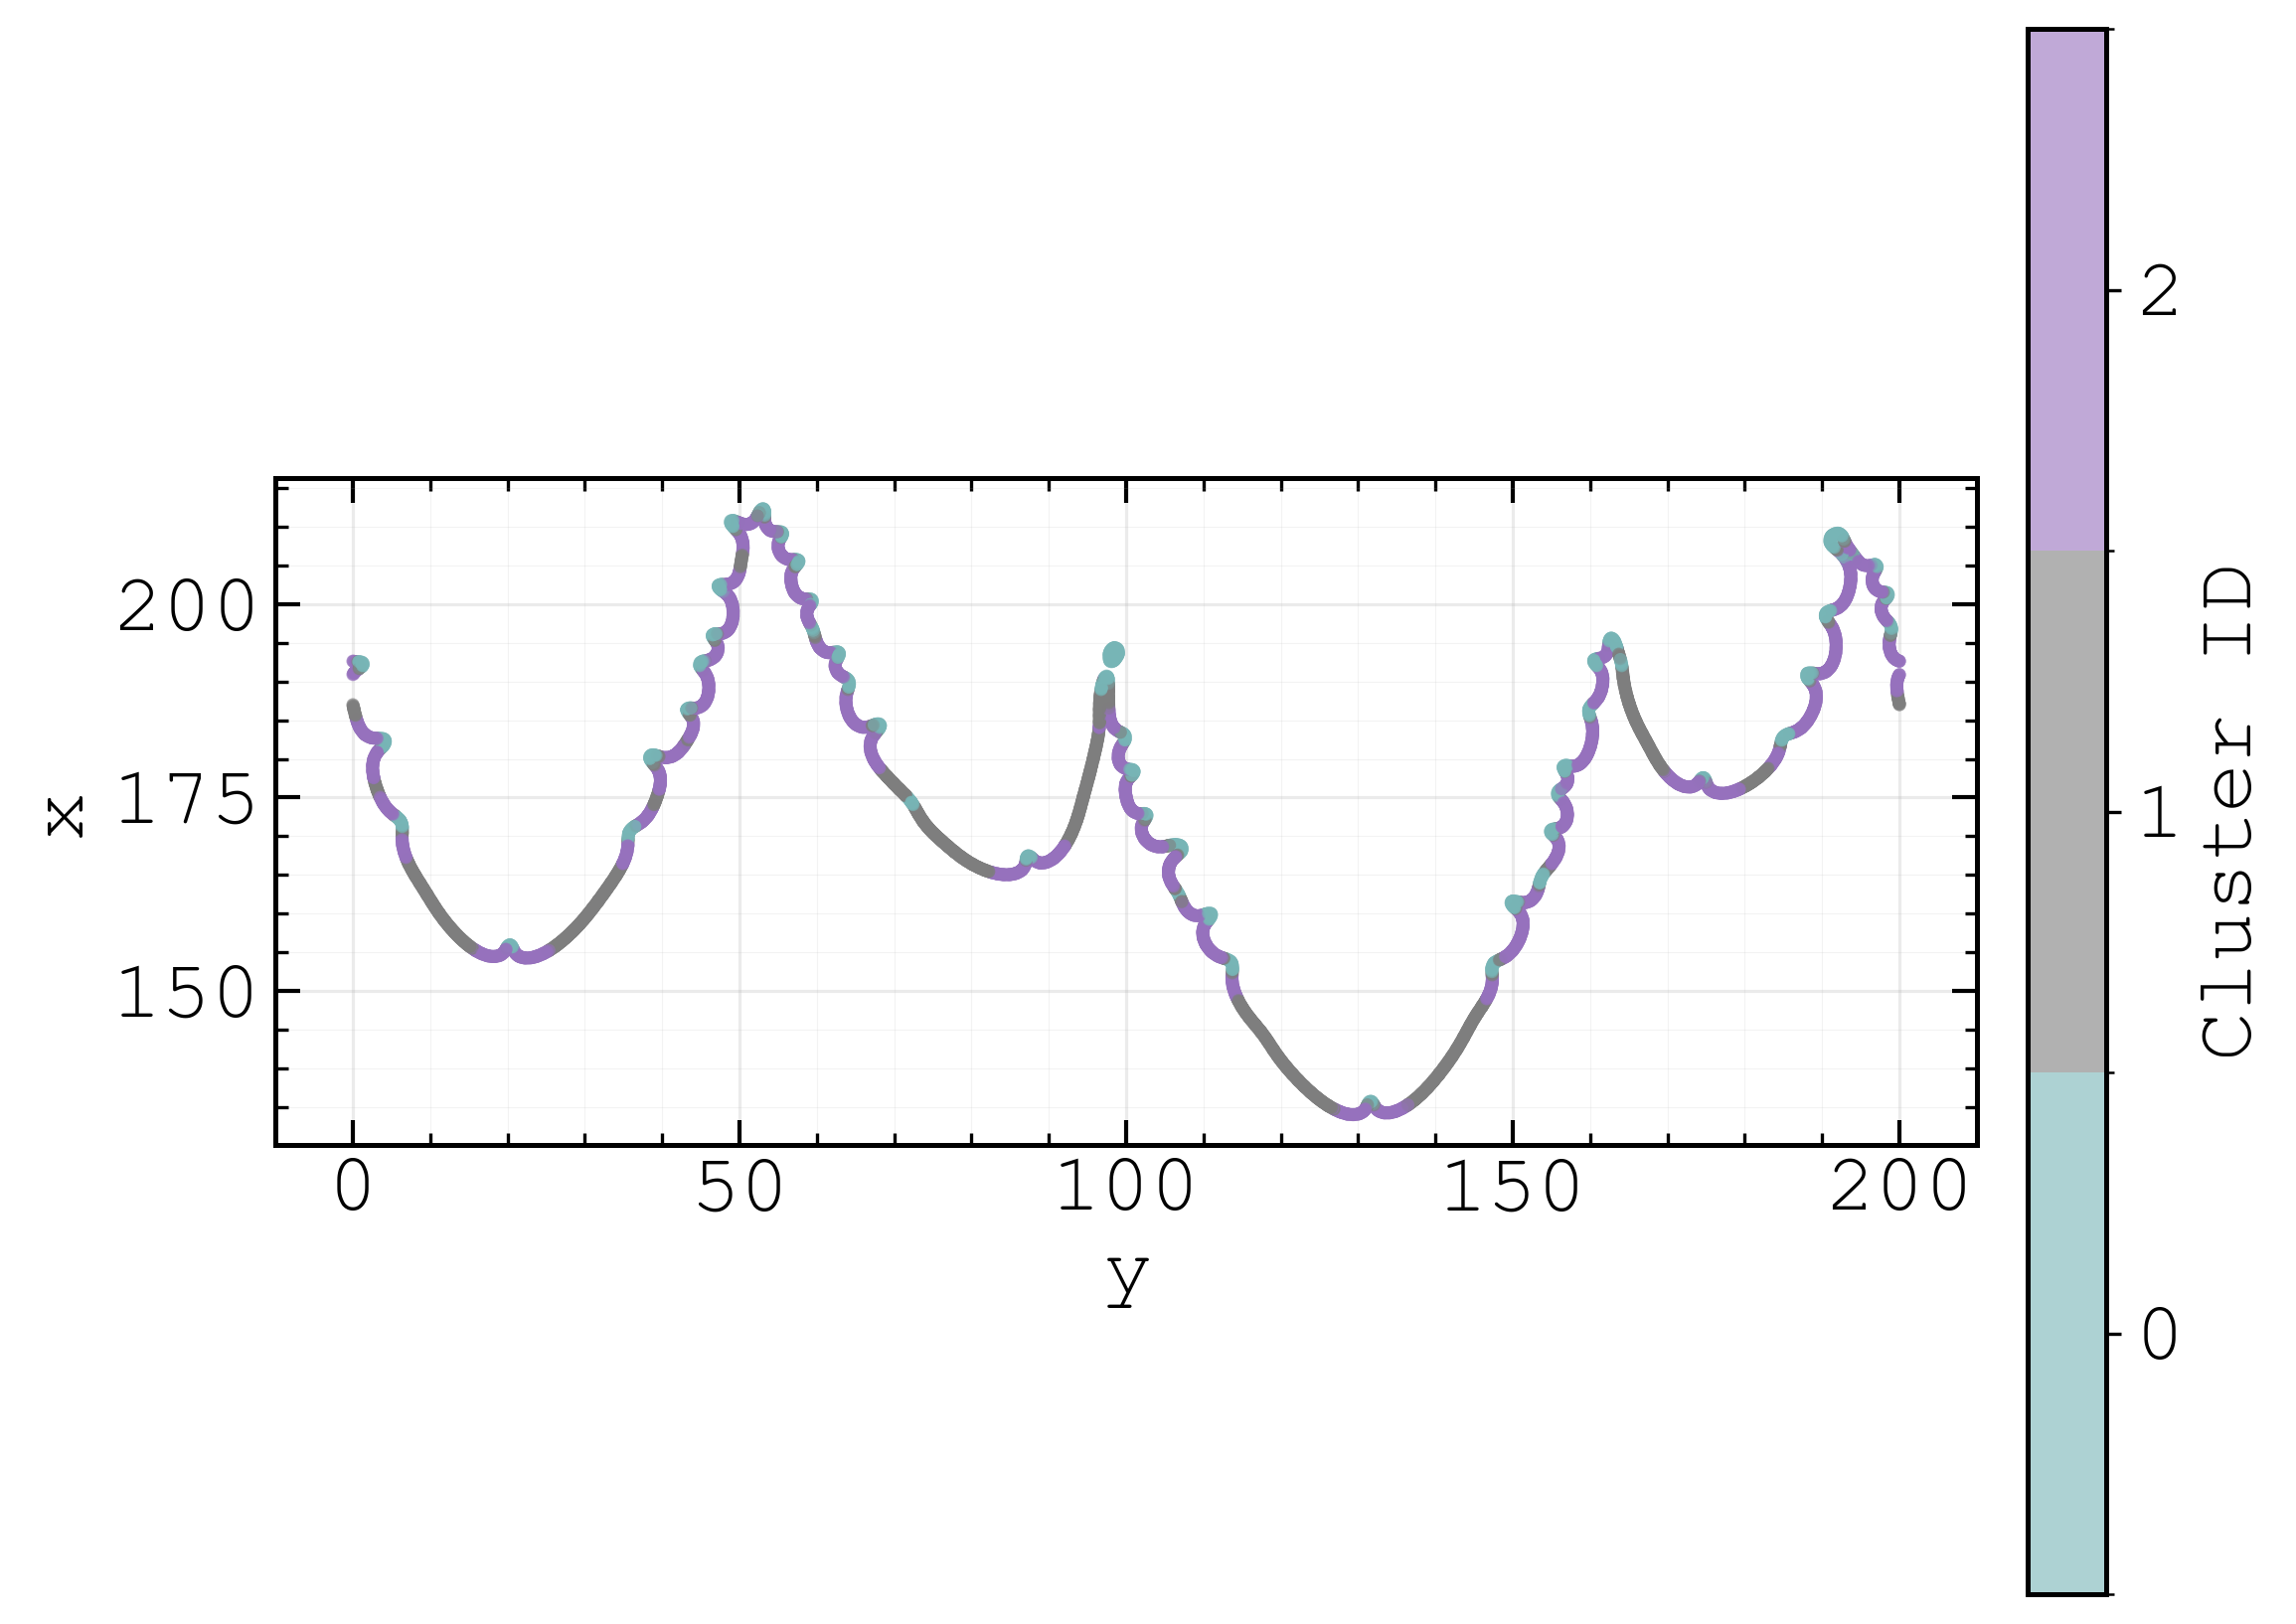

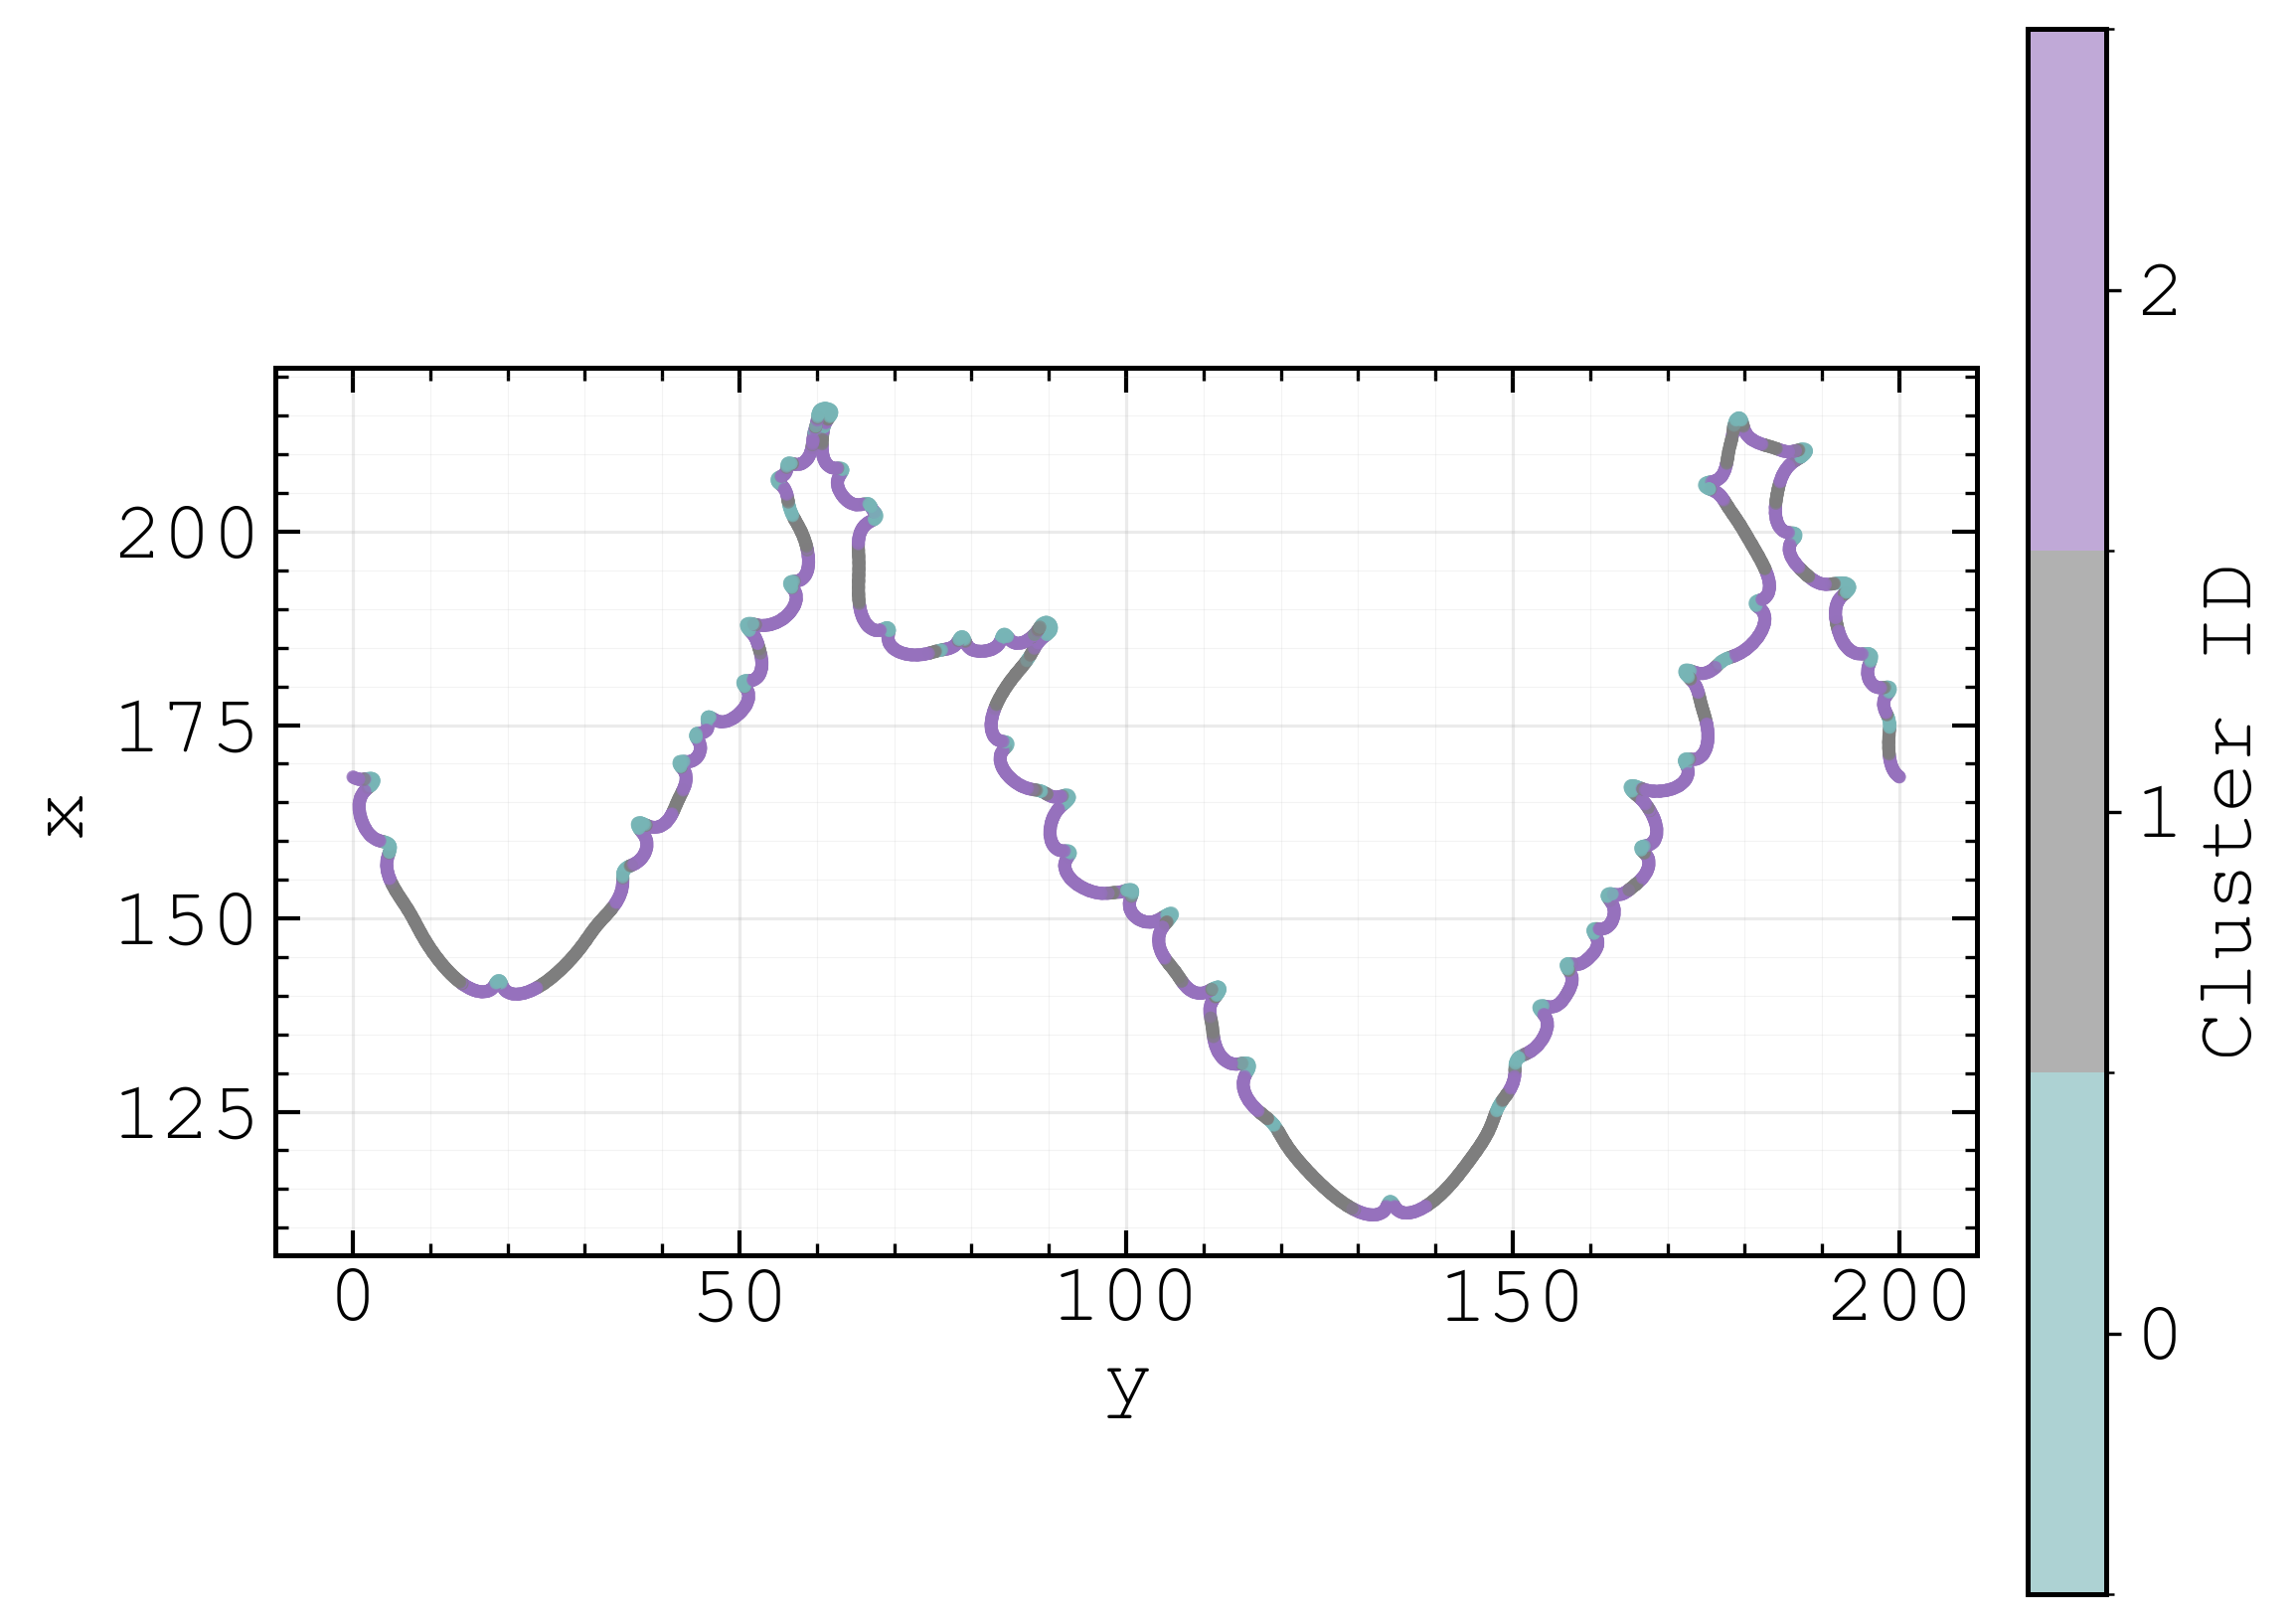


Curvature-bin cluster summary (pooled):
 cluster    n  sd_mean   sd_std  conf_mean  conf_max
       0 3109 1.278690 0.467967        1.0       1.0
       1 5985 1.237315 0.157540        1.0       1.0
       2 9433 1.371238 0.223946        1.0       1.0

Cluster occupancy / Sd mean by timestep:
 timestep  cluster    n  sd_mean  conf_mean
      200        0 1120 1.182634        1.0
      200        1 2360 1.237847        1.0
      200        2 3011 1.329008        1.0
      210        0  965 1.325046        1.0
      210        1 1880 1.224198        1.0
      210        2 2866 1.377167        1.0
      220        0 1024 1.340066        1.0
      220        1 1745 1.250729        1.0
      220        2 3556 1.402216        1.0


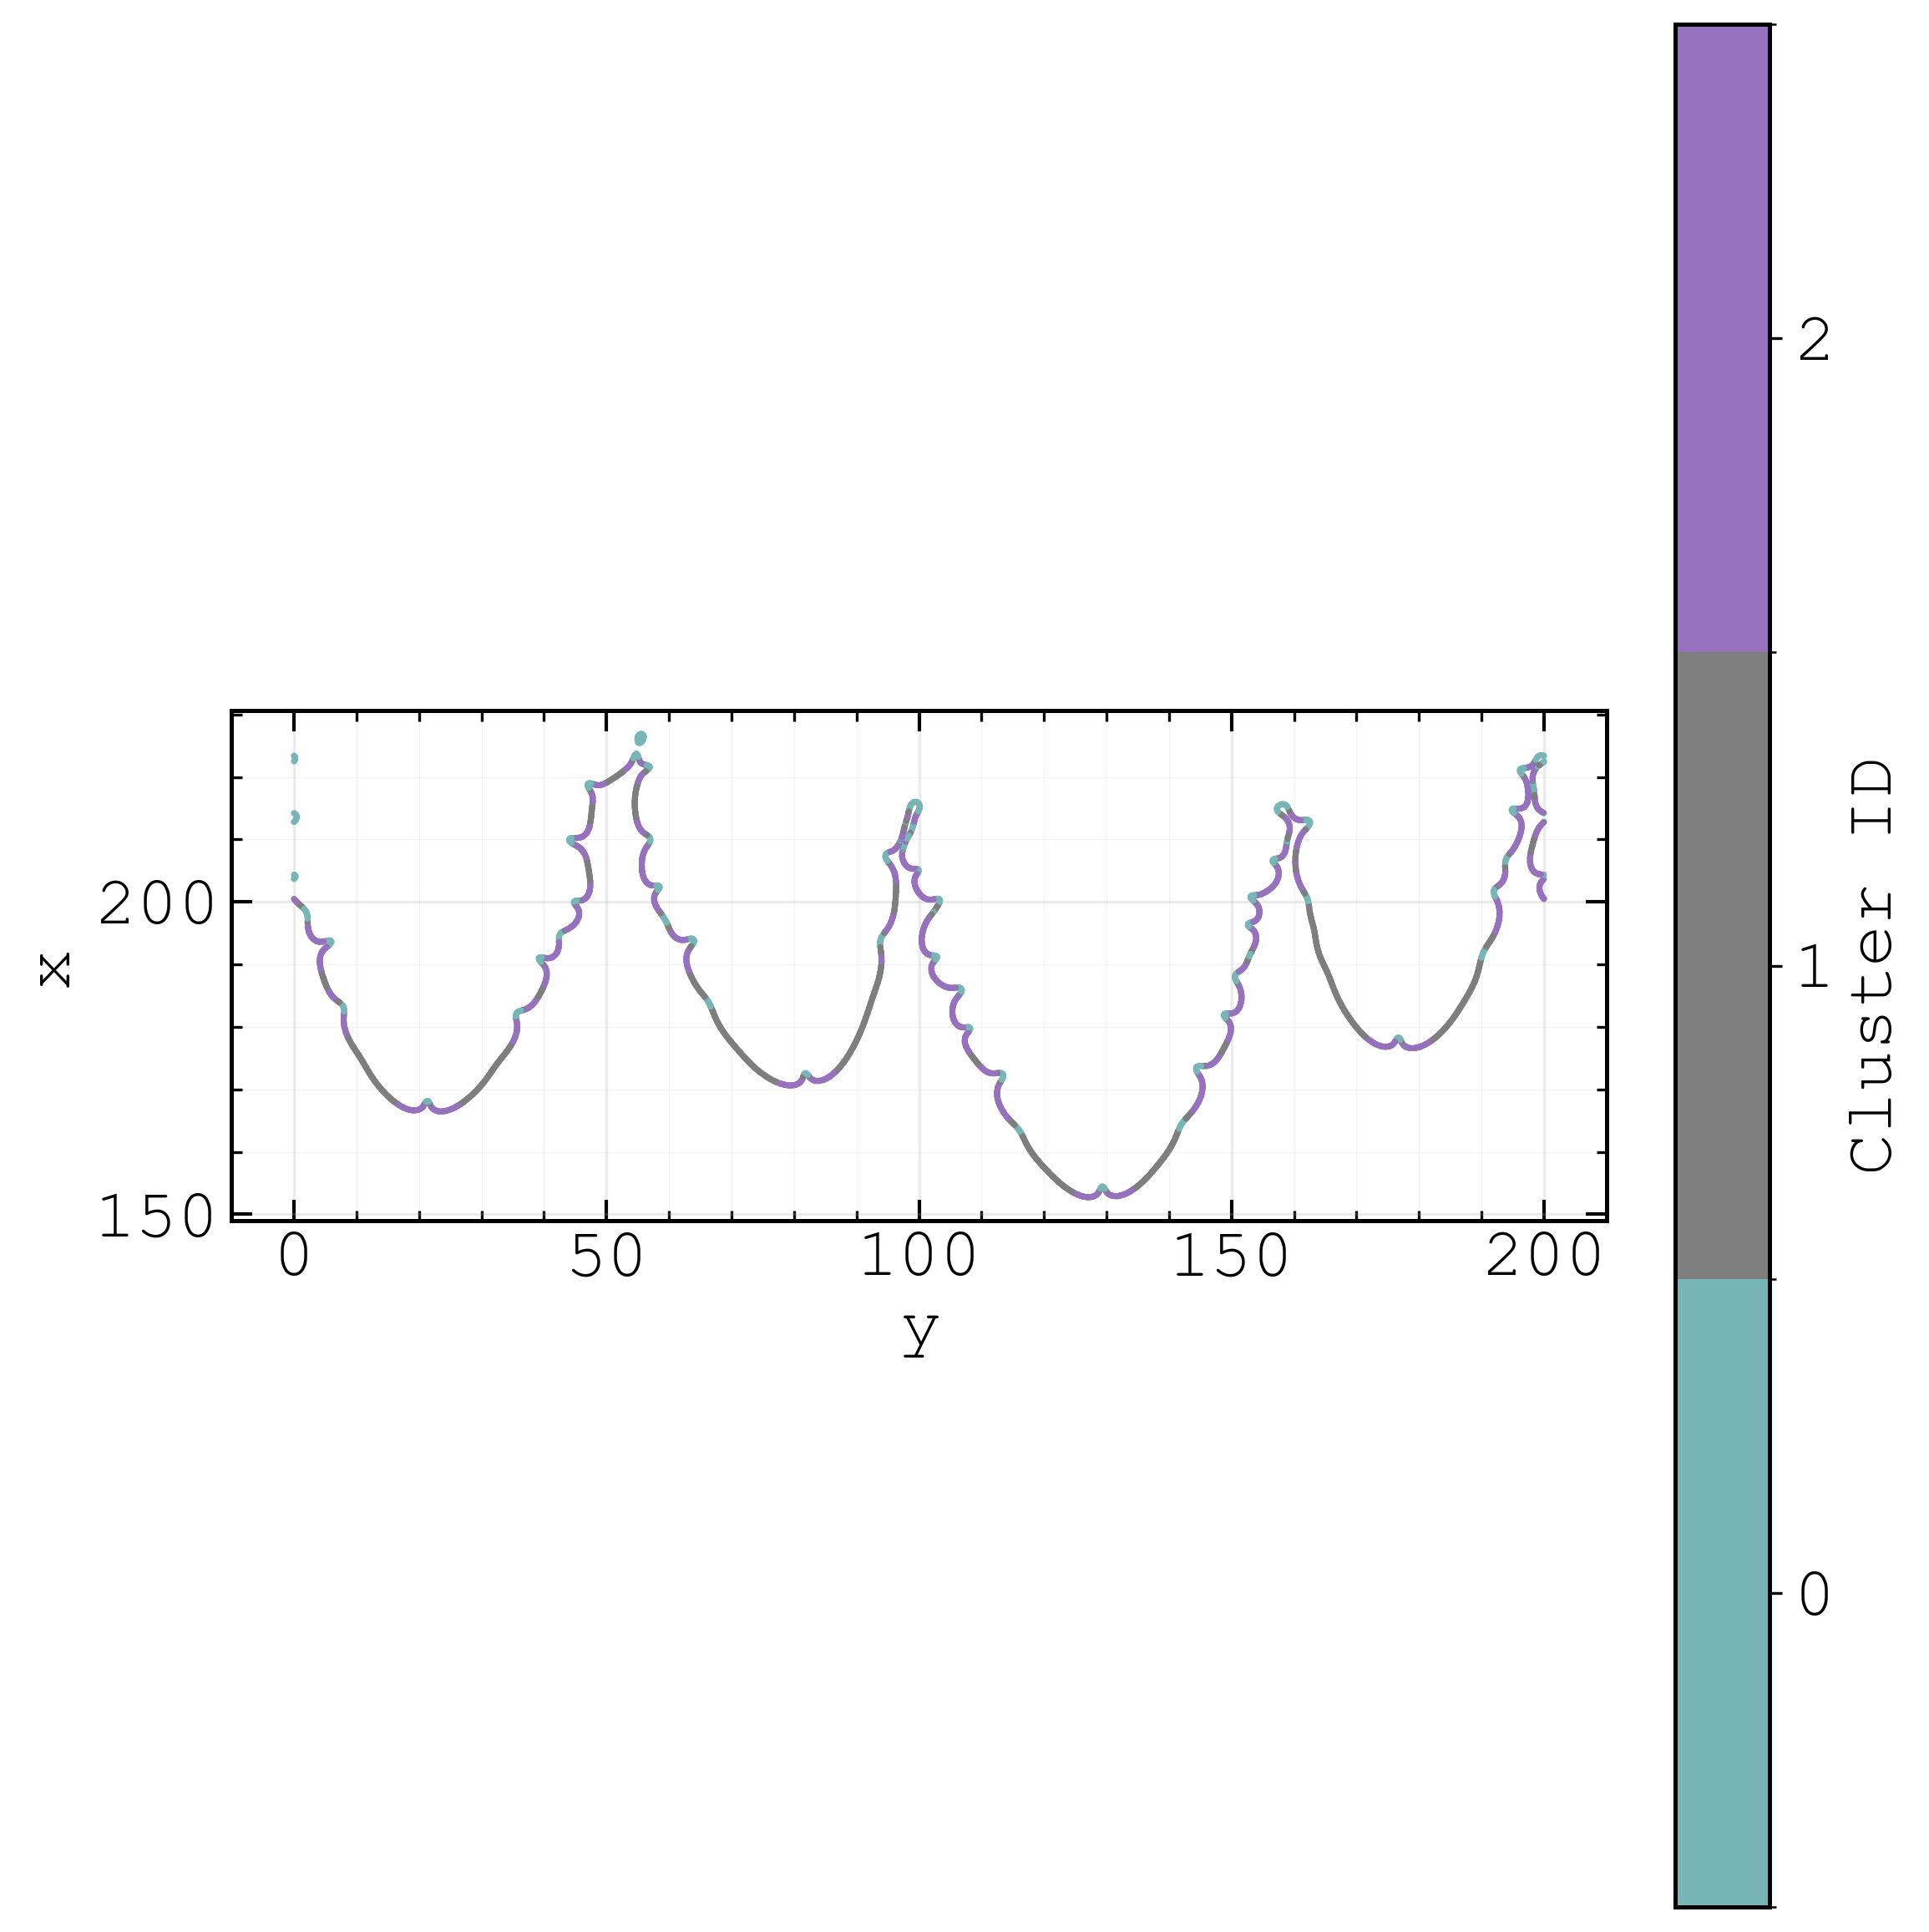

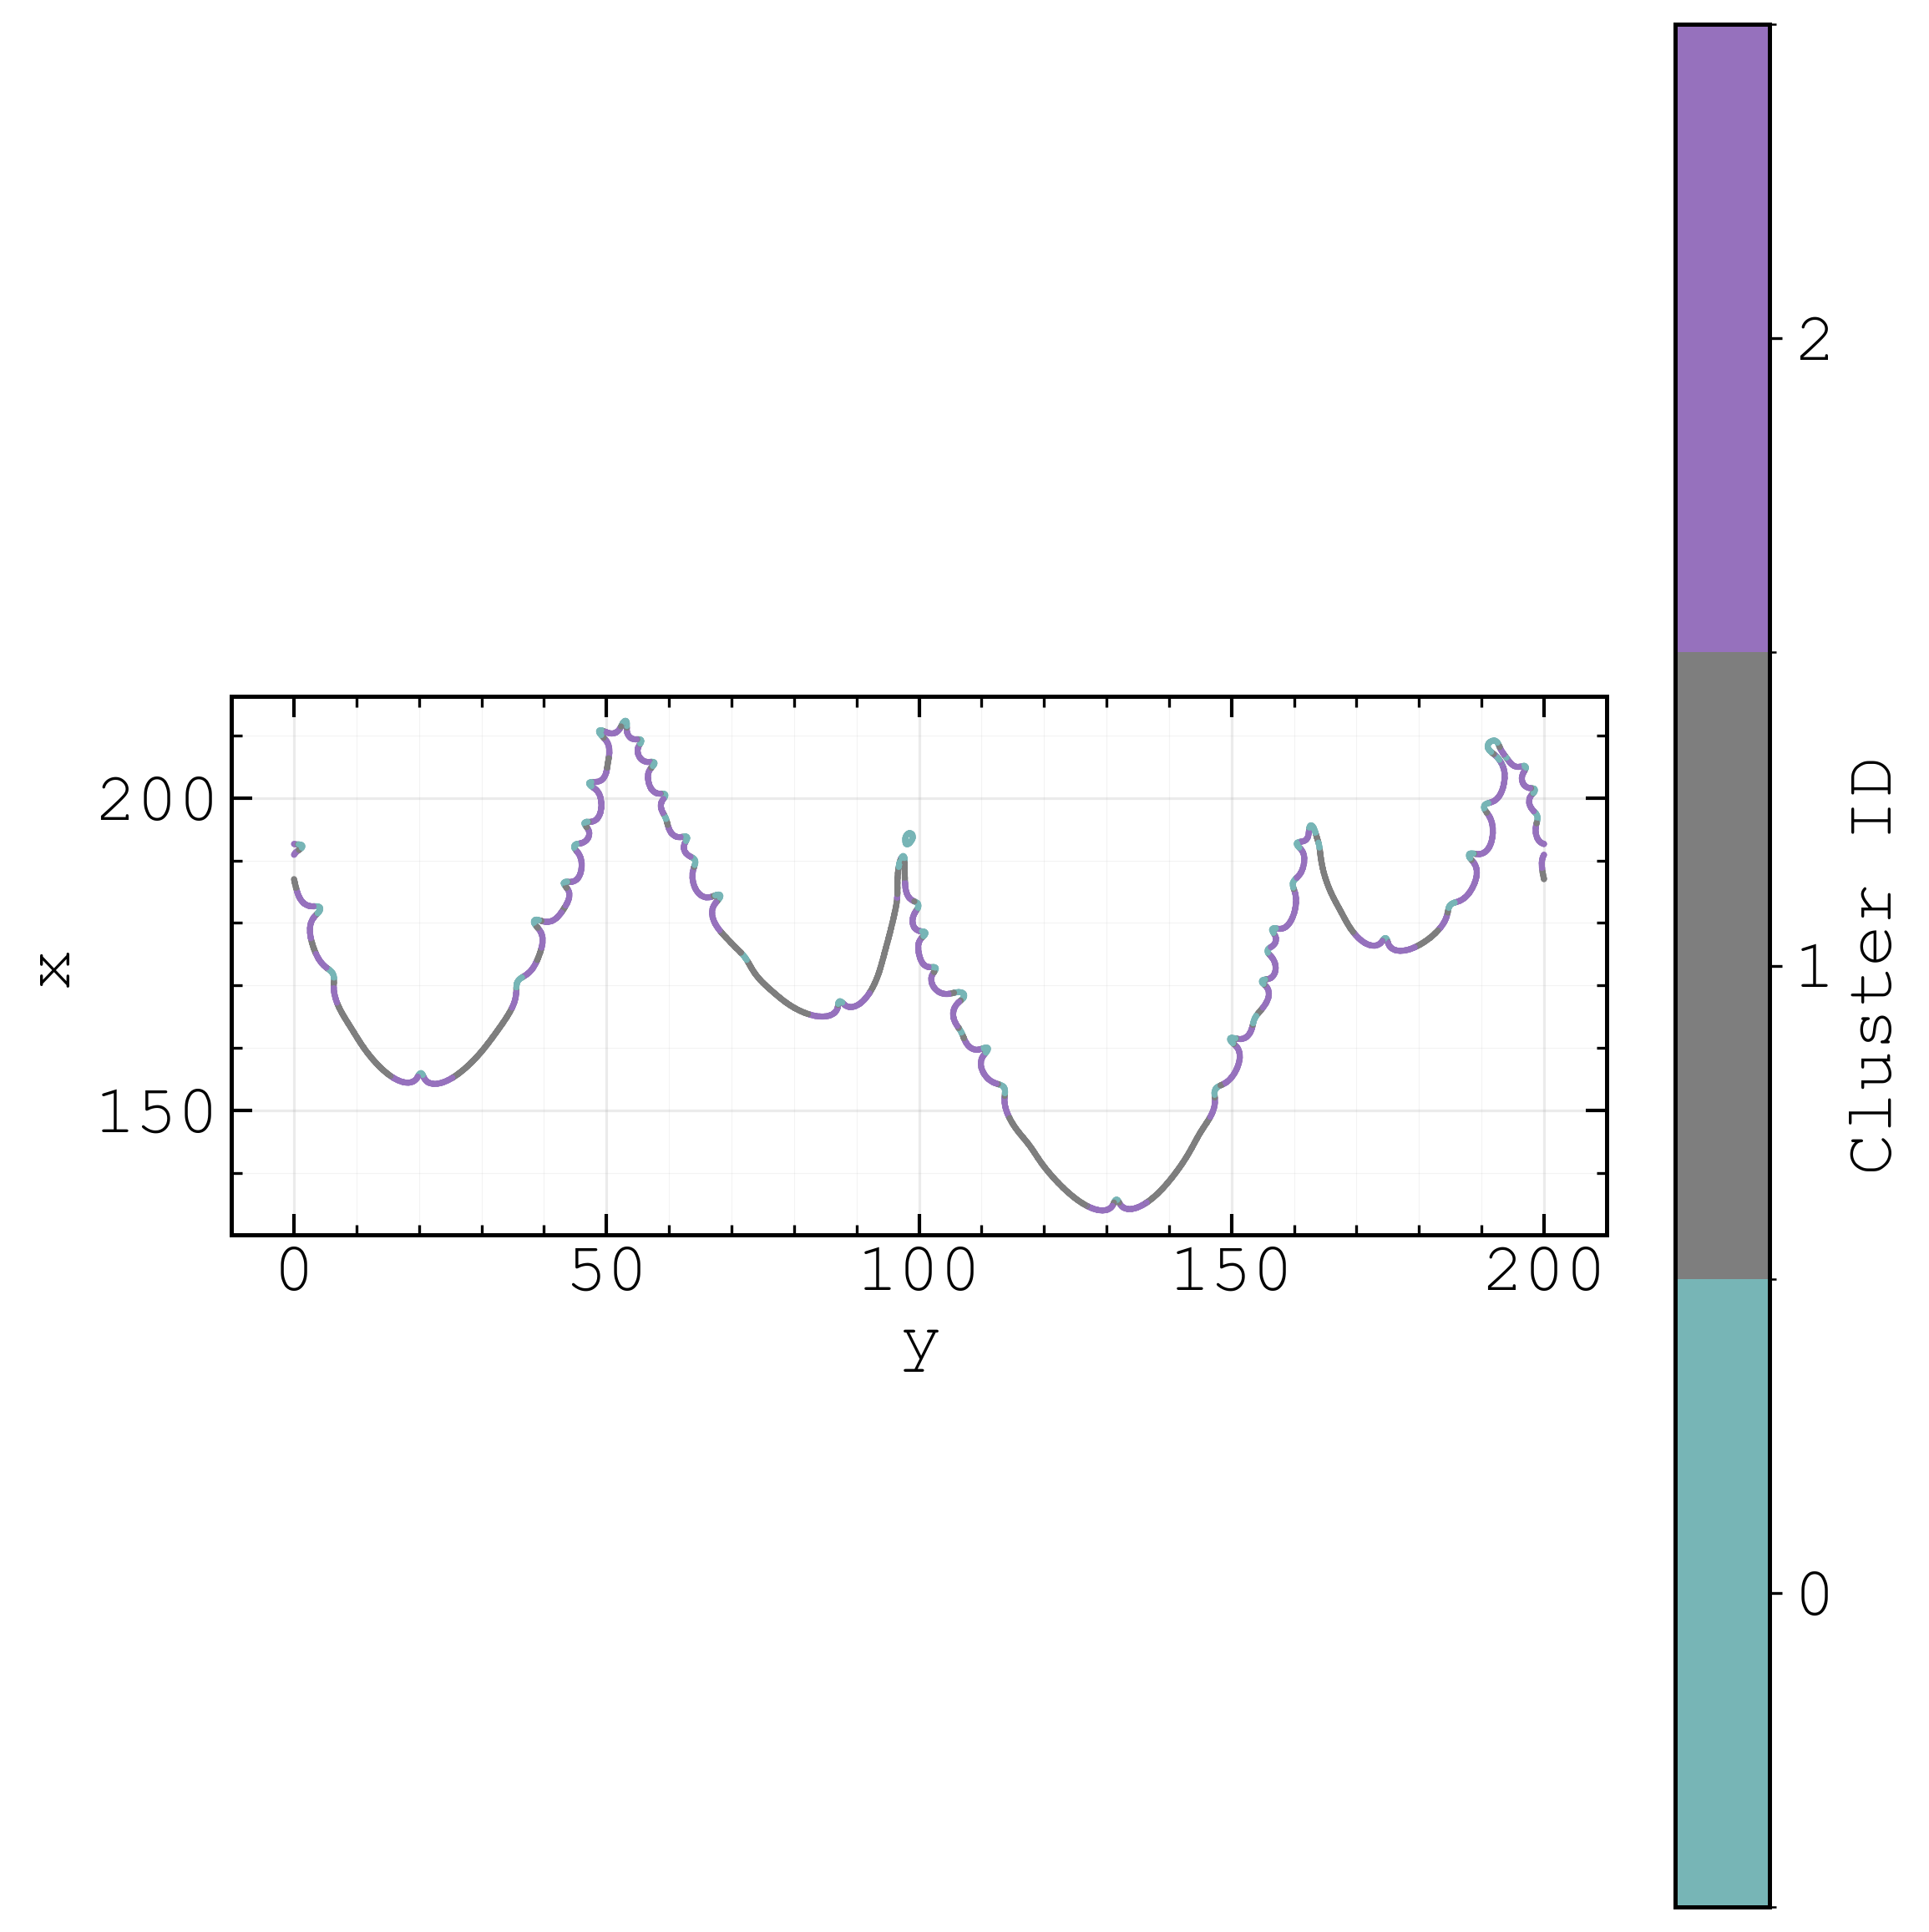

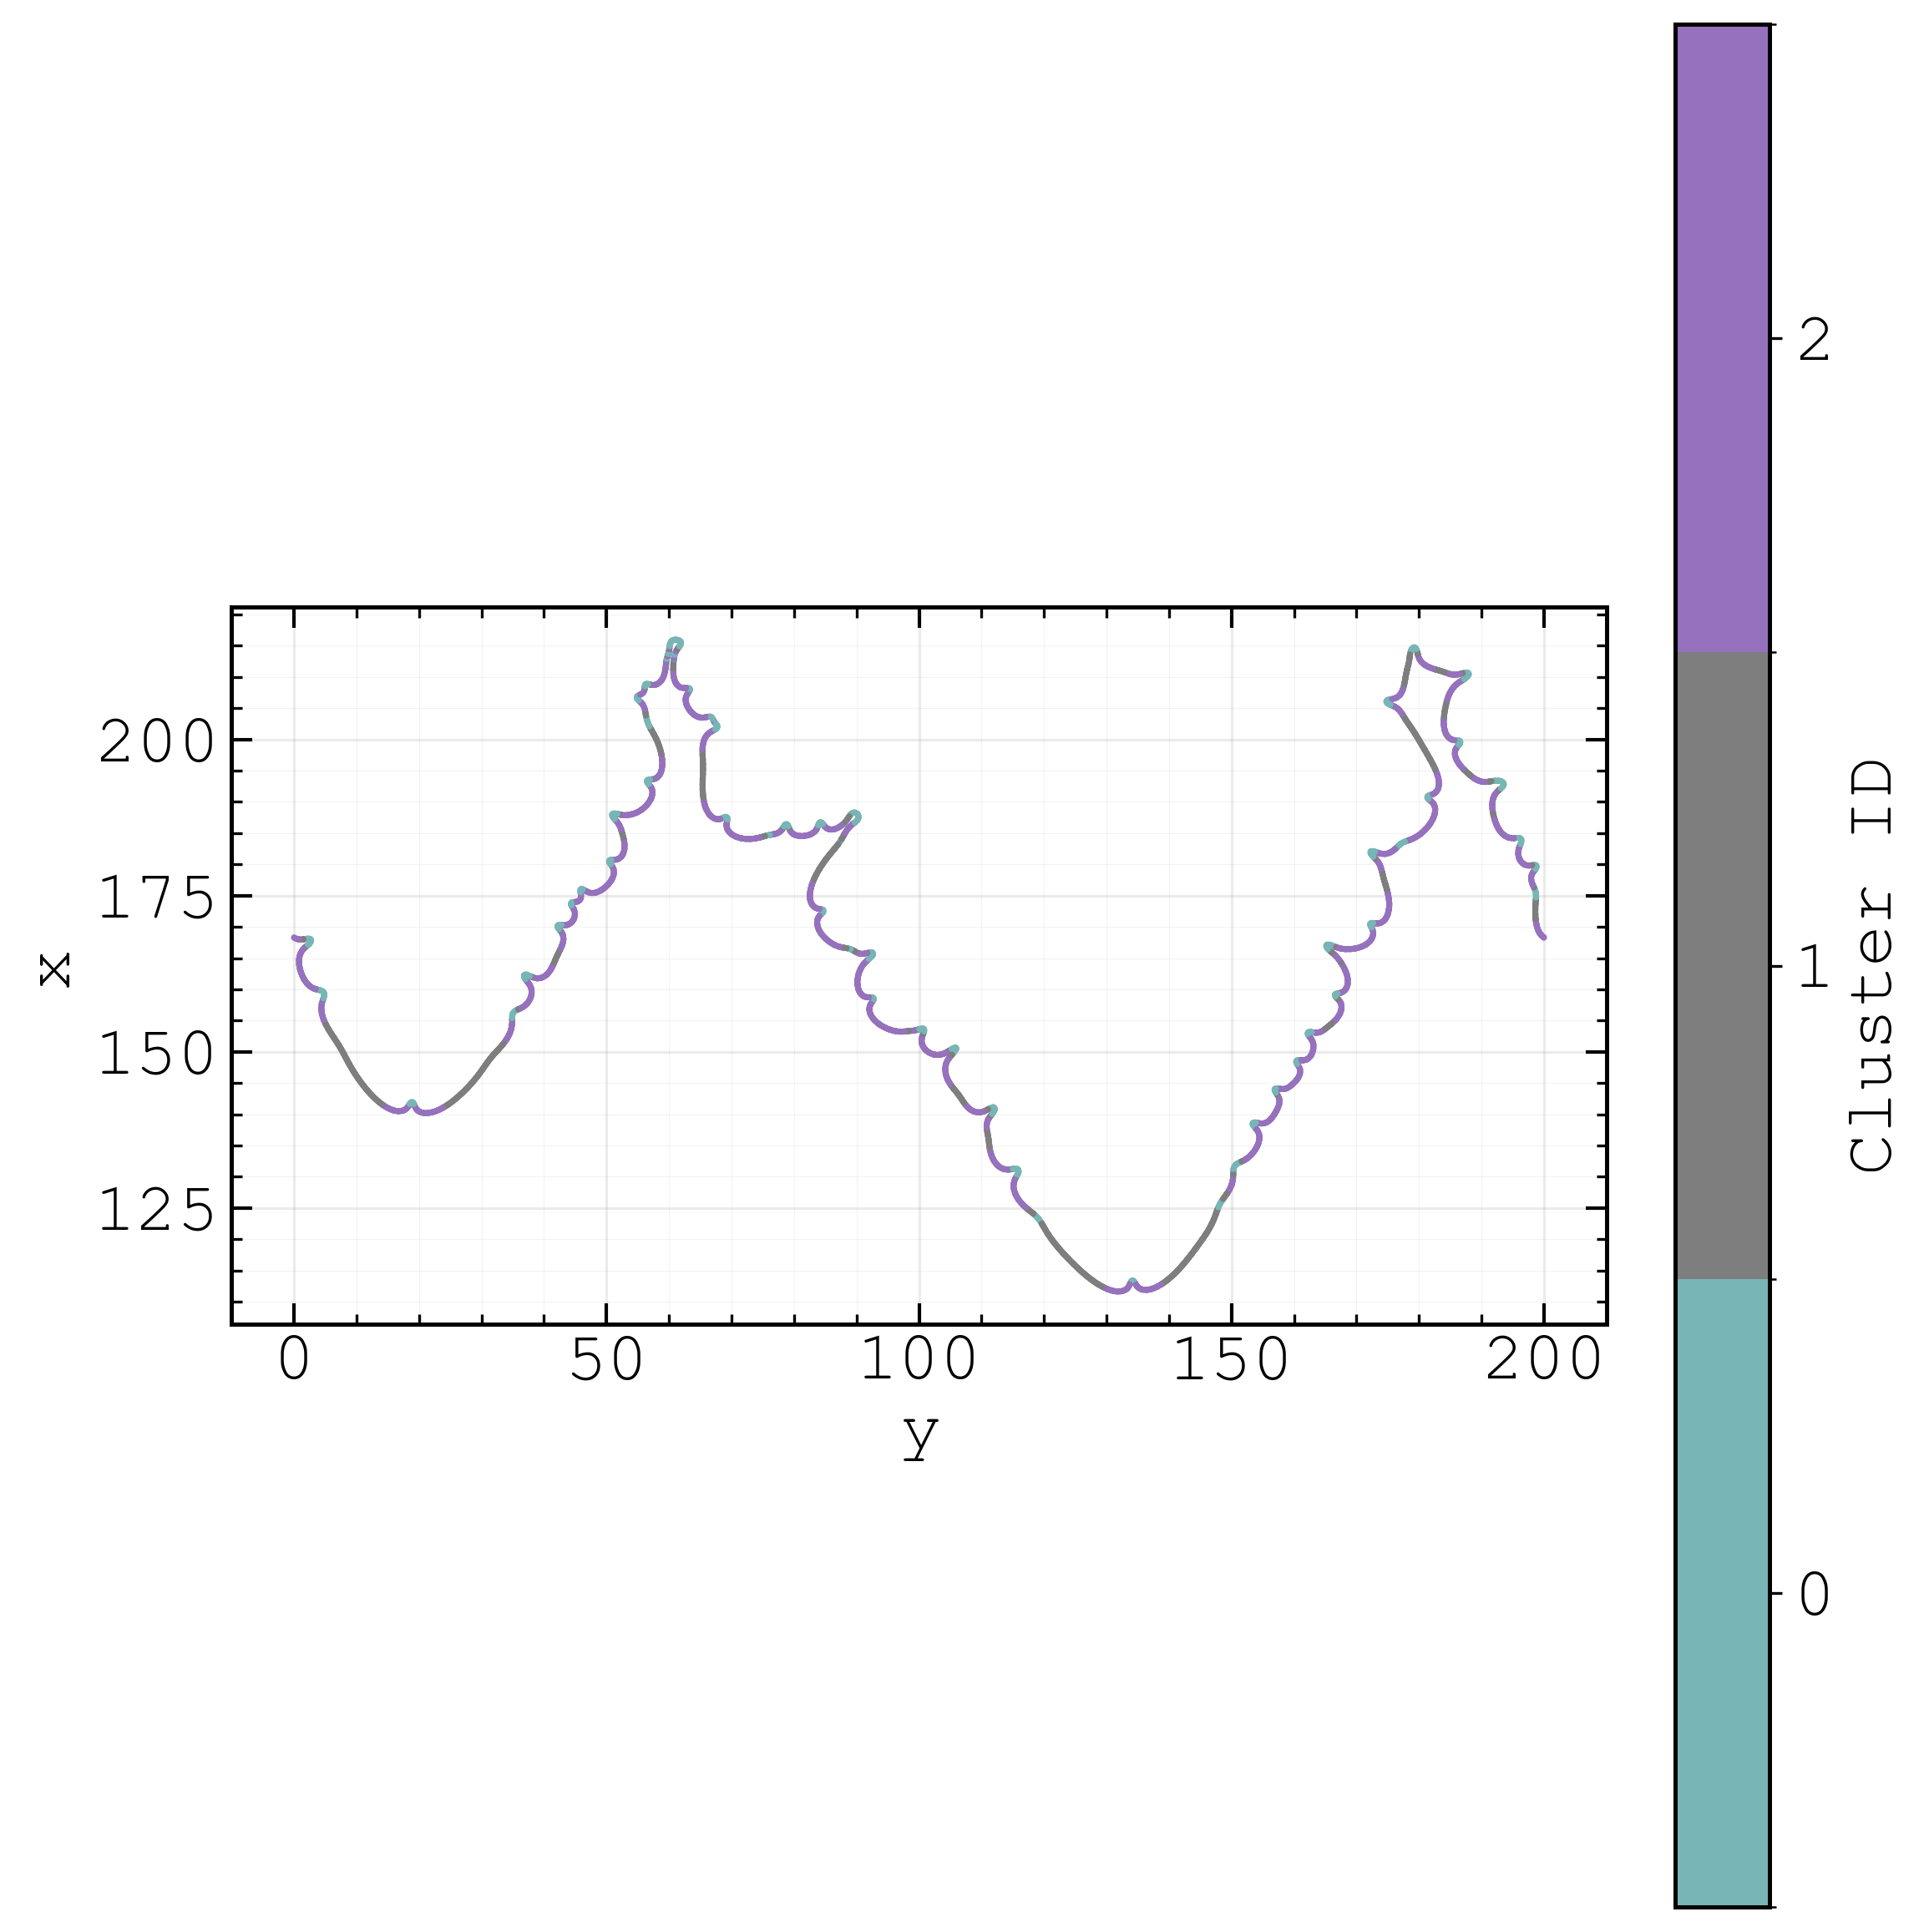

In [5]:
curv_col = CURVATURE_COLUMN
if curv_col not in dfc.columns:
    raise ValueError(f"CURVATURE_COLUMN '{curv_col}' not found in dataframe")

if len(CURVATURE_BOUNDS) != 2:
    raise ValueError("CURVATURE_BOUNDS must contain exactly two values")
low, high = CURVATURE_BOUNDS
if low >= high:
    raise ValueError("CURVATURE_BOUNDS must be strictly increasing (low < high)")

dfc["cluster"] = np.digitize(
    dfc[curv_col].to_numpy(),
    bins=[low, high],
    right=True,
)
dfc["cluster_conf"] = 1.0

print(f"\nCurvature bins: {CURVATURE_BOUNDS} -> clusters 0..{N_CLUSTERS - 1}")

for ts in TIME_STEPS:
    sub = dfc[dfc["timestep"] == ts].copy()
    if len(sub) == 0:
        continue
    plot_isocontour_scatter(
        sub,
        save_stem=f"isocontour_xy_iso{ISOLEVEL}_ts{ts}",
    )

summary_global = (
    dfc.groupby("cluster")
    .agg(
        n=(TARGET_VAR, "size"),
        sd_mean=(TARGET_VAR, "mean"),
        sd_std=(TARGET_VAR, "std"),
        conf_mean=("cluster_conf", "mean"),
        conf_max=("cluster_conf", "max"),
    )
    .reset_index()
    .sort_values("cluster")
)
print("\nCurvature-bin cluster summary (pooled):")
print(summary_global.to_string(index=False))

summary_by_t = (
    dfc.groupby(["timestep", "cluster"])
    .agg(n=(TARGET_VAR, "size"), sd_mean=(TARGET_VAR, "mean"), conf_mean=("cluster_conf", "mean"))
    .reset_index()
    .sort_values(["timestep", "cluster"])
)
print("\nCluster occupancy / Sd mean by timestep:")
print(summary_by_t.to_string(index=False))

for ts in TIME_STEPS:
    sub = dfc[dfc["timestep"] == ts]
    if len(sub) == 0:
        continue
    labeled_cluster_plot_xy(
        sub, N_CLUSTERS,
        title=f"CURVATURE bins | isotherm {ISOLEVEL} | timestep {ts}"
    )


### Per-cluster selection on representatives (JMI vs CMIM)

In [6]:
jmi_rows: List[dict] = []
cmim_rows: List[dict] = []
compare_rows: List[dict] = []

if "rep_features" not in locals() or len(rep_features) == 0:
    rep_csv = SAVE_DIR / "mi_cluster_representatives.csv"
    if rep_csv.exists():
        rep_info_df = pd.read_csv(rep_csv)
        rep_features = rep_info_df["representative"].dropna().tolist()
    else:
        rep_features = list(model_features)

rep_features = [f for f in rep_features if f in dfc.columns]

if not rep_features:
    print("[WARN] No representative features available; skipping selection.")
else:
    for cl in range(N_CLUSTERS):
        sub = dfc[dfc["cluster"] == cl].copy()
        n_cl = len(sub)
        print(f"\n--- Cluster {cl} (representatives) | n={n_cl} ---")

        if n_cl < MIN_CLUSTER_SAMPLES:
            print(f"Skipping (n < MIN_CLUSTER_SAMPLES={MIN_CLUSTER_SAMPLES})")
            continue

        sub = sub.dropna(subset=rep_features + [TARGET_VAR])
        if len(sub) < MIN_CLUSTER_SAMPLES:
            print(f"Skipping after dropna (n < MIN_CLUSTER_SAMPLES={MIN_CLUSTER_SAMPLES})")
            continue

        jmi_sel, jmi_hist = select_jmi_features(
            df=sub,
            target_var=TARGET_VAR,
            features=rep_features,
            k_select=TOPK_REP_PRED,
            random_state=RANDOM_STATE,
        )

        cmim_sel, cmim_hist = select_cmim_features(
            df=sub,
            target_var=TARGET_VAR,
            features=rep_features,
            k_select=TOPK_REP_PRED,
            random_state=RANDOM_STATE,
        )

        print(f"JMI top-{TOPK_REP_PRED}: {jmi_sel}")
        print(f"CMIM top-{TOPK_REP_PRED}: {cmim_sel}")

        for rank, feat in enumerate(jmi_sel, 1):
            score = float(jmi_hist.get(rank, pd.Series()).get(feat, np.nan))
            jmi_rows.append({
                "cluster": cl,
                "rank": rank,
                "feature": feat,
                "score": score,
                "n_cluster": int(n_cl),
            })

        for rank, feat in enumerate(cmim_sel, 1):
            score = float(cmim_hist.get(rank, pd.Series()).get(feat, np.nan))
            cmim_rows.append({
                "cluster": cl,
                "rank": rank,
                "feature": feat,
                "score": score,
                "n_cluster": int(n_cl),
            })

        overlap = sorted(set(jmi_sel).intersection(cmim_sel))
        compare_rows.append({
            "cluster": cl,
            "jmi_top": ", ".join(jmi_sel),
            "cmim_top": ", ".join(cmim_sel),
            "overlap": ", ".join(overlap),
            "overlap_count": int(len(overlap)),
        })

        # Save per-step rankings for inspection
        if jmi_hist:
            jmi_step_rows = []
            for step, series in jmi_hist.items():
                for feat, score in series.items():
                    jmi_step_rows.append({
                        "cluster": cl,
                        "step": step,
                        "feature": feat,
                        "score": float(score),
                    })
            pd.DataFrame(jmi_step_rows).to_csv(
                SAVE_DIR / f"jmi_rankings_cluster_{cl}.csv", index=False
            )

        if cmim_hist:
            cmim_step_rows = []
            for step, series in cmim_hist.items():
                for feat, score in series.items():
                    cmim_step_rows.append({
                        "cluster": cl,
                        "step": step,
                        "feature": feat,
                        "score": float(score),
                    })
            pd.DataFrame(cmim_step_rows).to_csv(
                SAVE_DIR / f"cmim_rankings_cluster_{cl}.csv", index=False
            )



--- Cluster 0 (representatives) | n=3109 ---
JMI top-4: ['curvature', 'du_ndy', 'normal_strain_rate', 'dcurvdx']
CMIM top-4: ['curvature', 'vorticity', 'dTdy', 'du_ndy']

--- Cluster 1 (representatives) | n=5985 ---
JMI top-4: ['vorticity', 'dTdx', 'u_n', 'du_ndx']
CMIM top-4: ['vorticity', 'dTdx', 'u_n', 'du_ndx']

--- Cluster 2 (representatives) | n=9433 ---
JMI top-4: ['du_ndy', 'du_ndx', 'dTdy', 'dTdx']
CMIM top-4: ['du_ndy', 'du_ndx', 'dTdx', 'u_n']


### Save summary tables

In [7]:
if jmi_rows:
    jmi_df = pd.DataFrame(jmi_rows)
    jmi_csv = SAVE_DIR / "jmi_selected_features.csv"
    jmi_df.to_csv(jmi_csv, index=False)
    print("\nSummary (JMI selected features per curvature cluster):")
    print(jmi_df.to_string(index=False))
    print(f"\n[INFO] Wrote JMI summary: {jmi_csv}")
else:
    print("\nNo JMI results to report.")

if cmim_rows:
    cmim_df = pd.DataFrame(cmim_rows)
    cmim_csv = SAVE_DIR / "cmim_selected_features.csv"
    cmim_df.to_csv(cmim_csv, index=False)
    print("\nSummary (CMIM selected features per curvature cluster):")
    print(cmim_df.to_string(index=False))
    print(f"\n[INFO] Wrote CMIM summary: {cmim_csv}")
else:
    print("\nNo CMIM results to report.")

if compare_rows:
    compare_df = pd.DataFrame(compare_rows)
    compare_csv = SAVE_DIR / "jmi_cmim_comparison.csv"
    compare_df.to_csv(compare_csv, index=False)
    print(f"\n[INFO] Wrote comparison: {compare_csv}")
print(f"\nSaved PNG plots + summary files to: {SAVE_DIR}")



Summary (JMI selected features per curvature cluster):
 cluster  rank            feature    score  n_cluster
       0     1          curvature 0.831620       3109
       0     2             du_ndy 0.890876       3109
       0     3 normal_strain_rate 1.019657       3109
       0     4            dcurvdx 0.978609       3109
       1     1          vorticity 1.036621       5985
       1     2               dTdx 1.949816       5985
       1     3                u_n 1.846843       5985
       1     4             du_ndx 1.796288       5985
       2     1             du_ndy 0.689468       9433
       2     2             du_ndx 0.882276       9433
       2     3               dTdy 0.994554       9433
       2     4               dTdx 0.801344       9433

[INFO] Wrote JMI summary: /media/alexandros/OS/Users/alexp/Documents/Bachelor Thesis/Code/report_figures/results/mi_cluster_jmi_cmim/lat_200/t_200_to_220/h_200_t_200_210_220_iso_0.6/jmi_selected_features.csv

Summary (CMIM selected features 


--- Cluster 0 (eval) | n=3109 ---


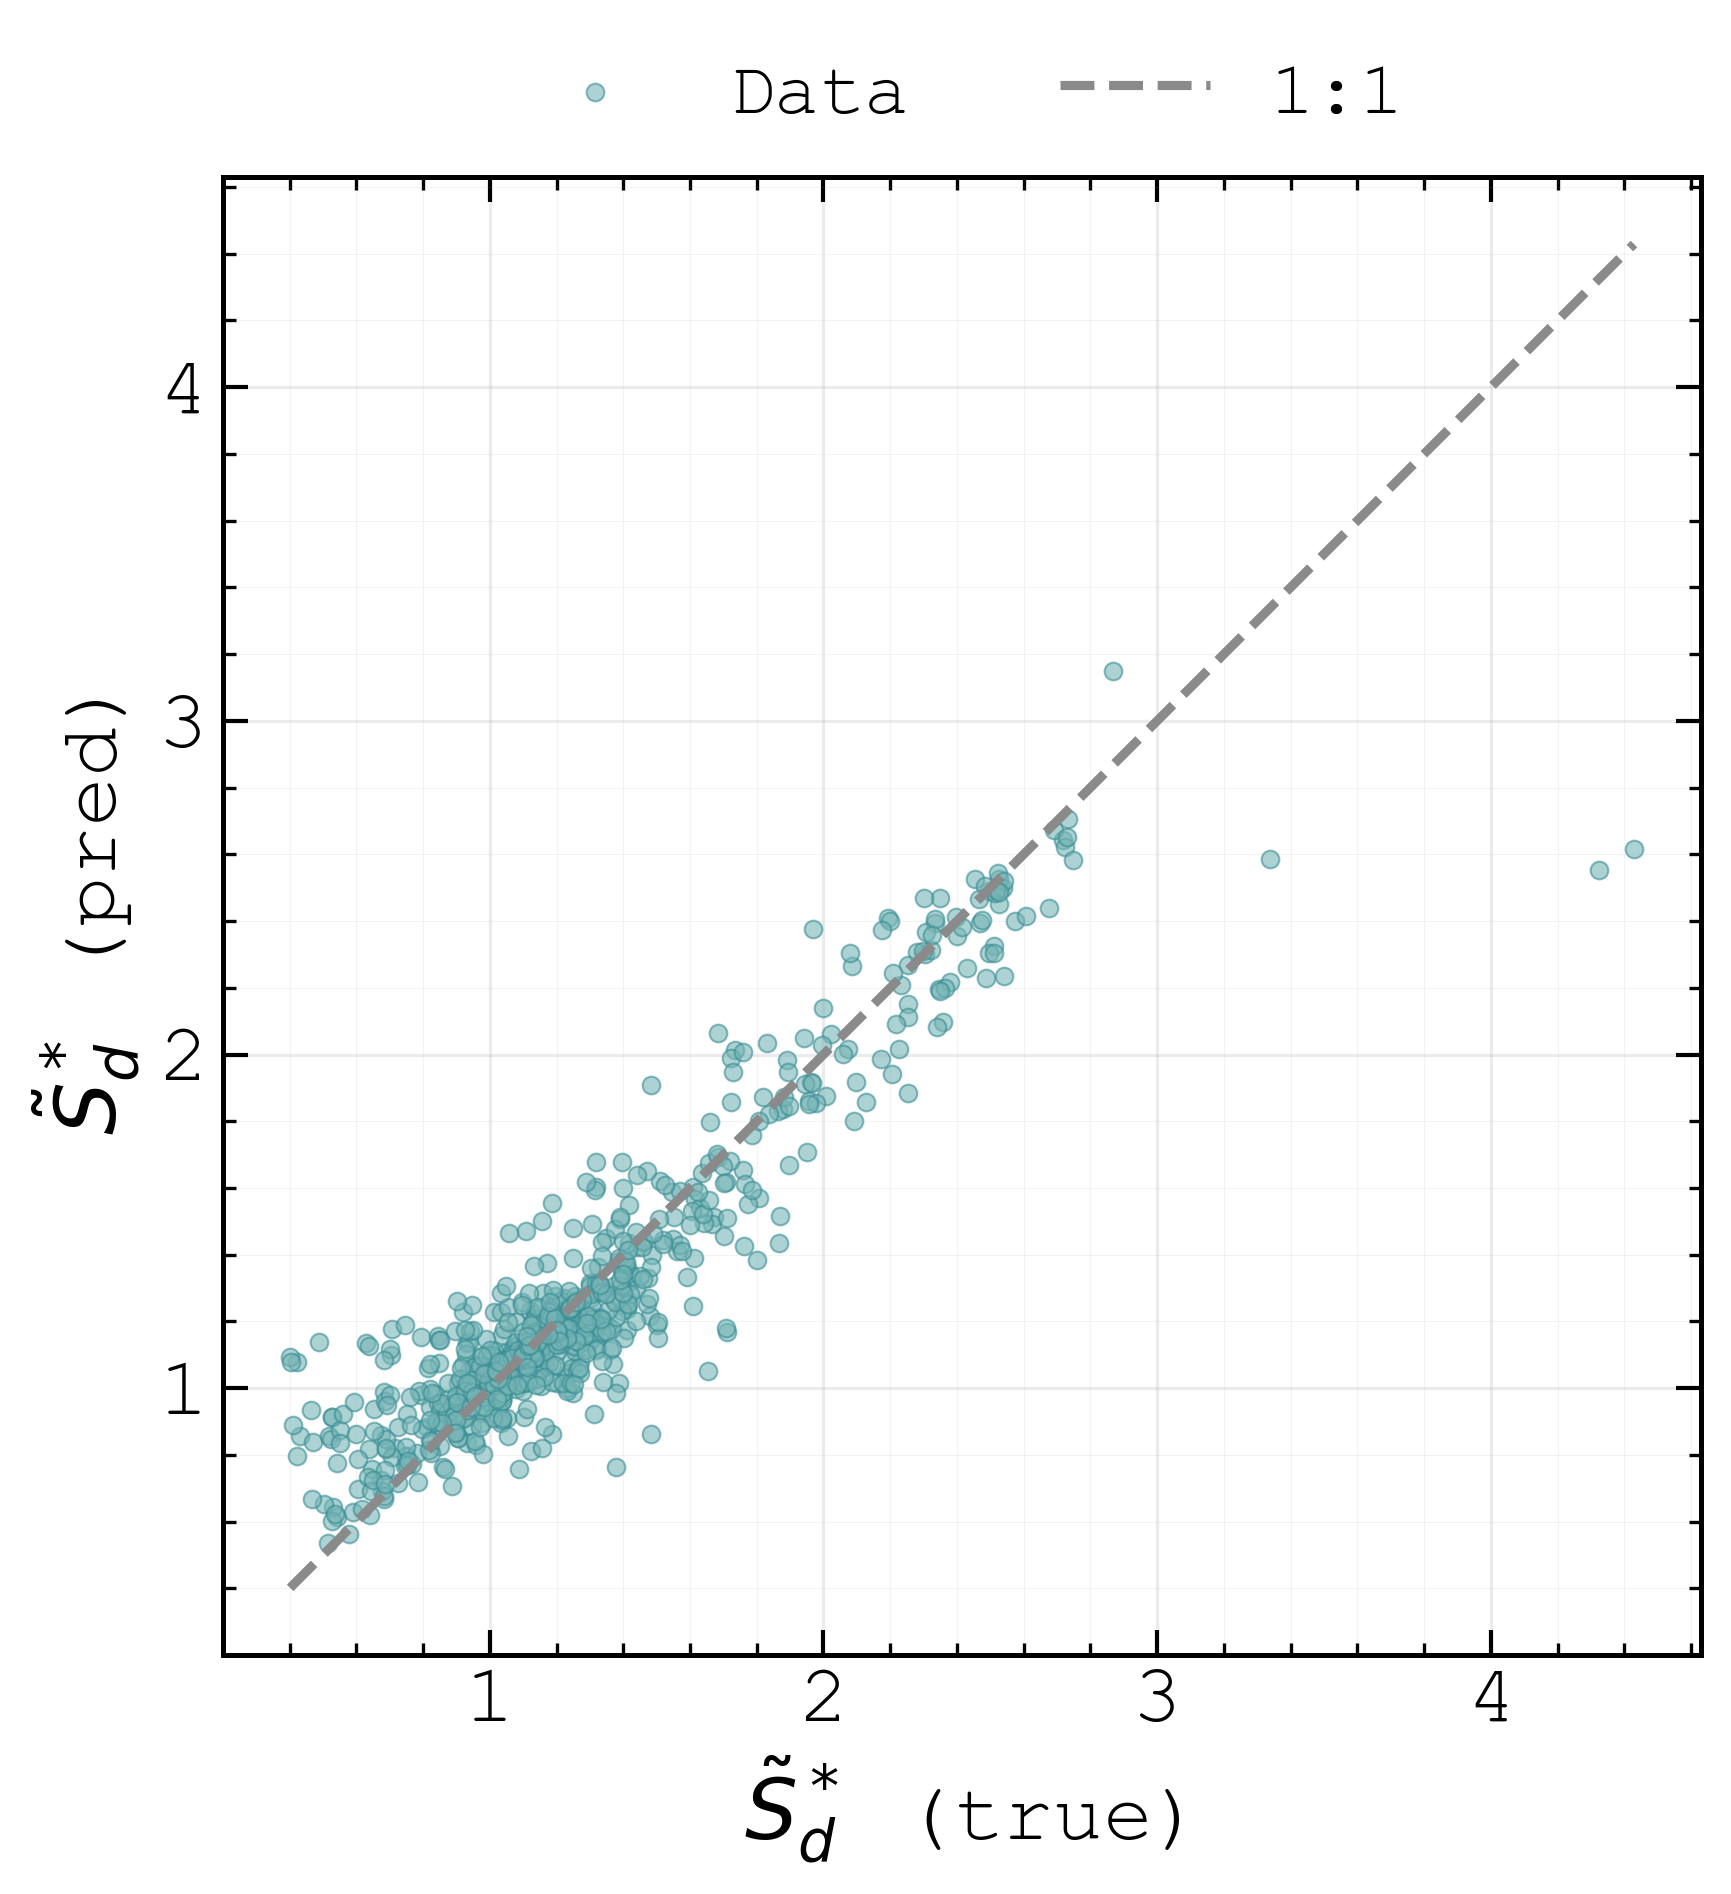

JMI top-4: ['curvature', 'du_ndy', 'normal_strain_rate', 'dcurvdx']
JMI RMSE: 1.868715e-01


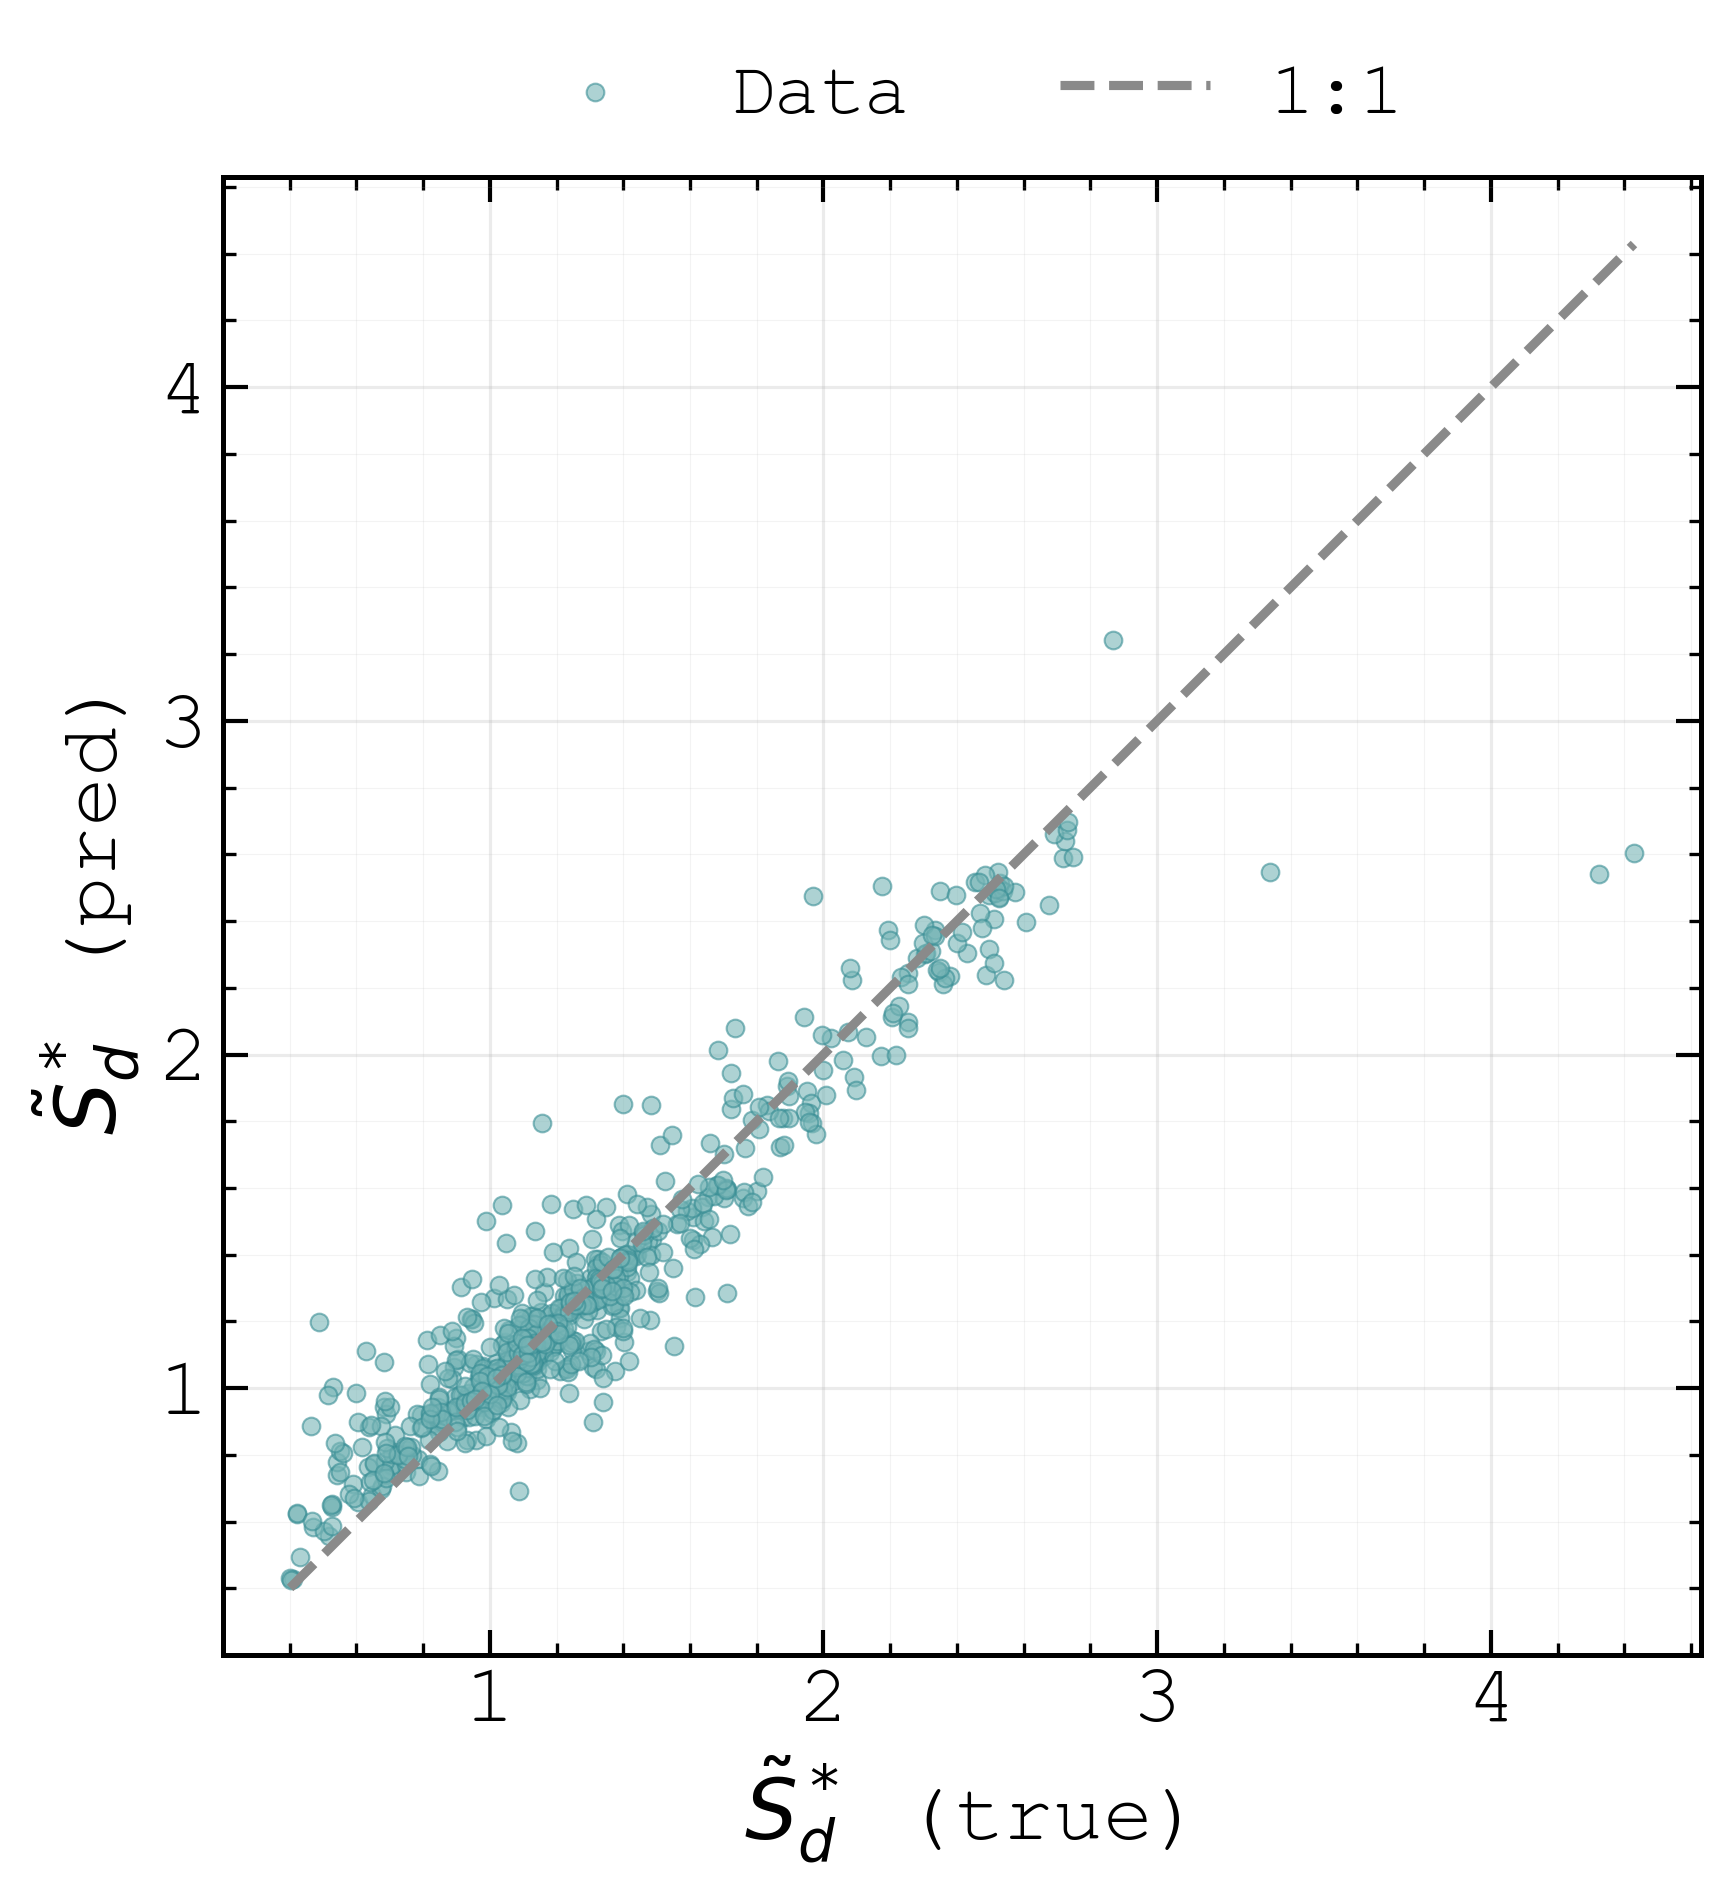

CMIM top-4: ['curvature', 'vorticity', 'dTdy', 'du_ndy']
CMIM RMSE: 1.633843e-01

--- Cluster 1 (eval) | n=5985 ---


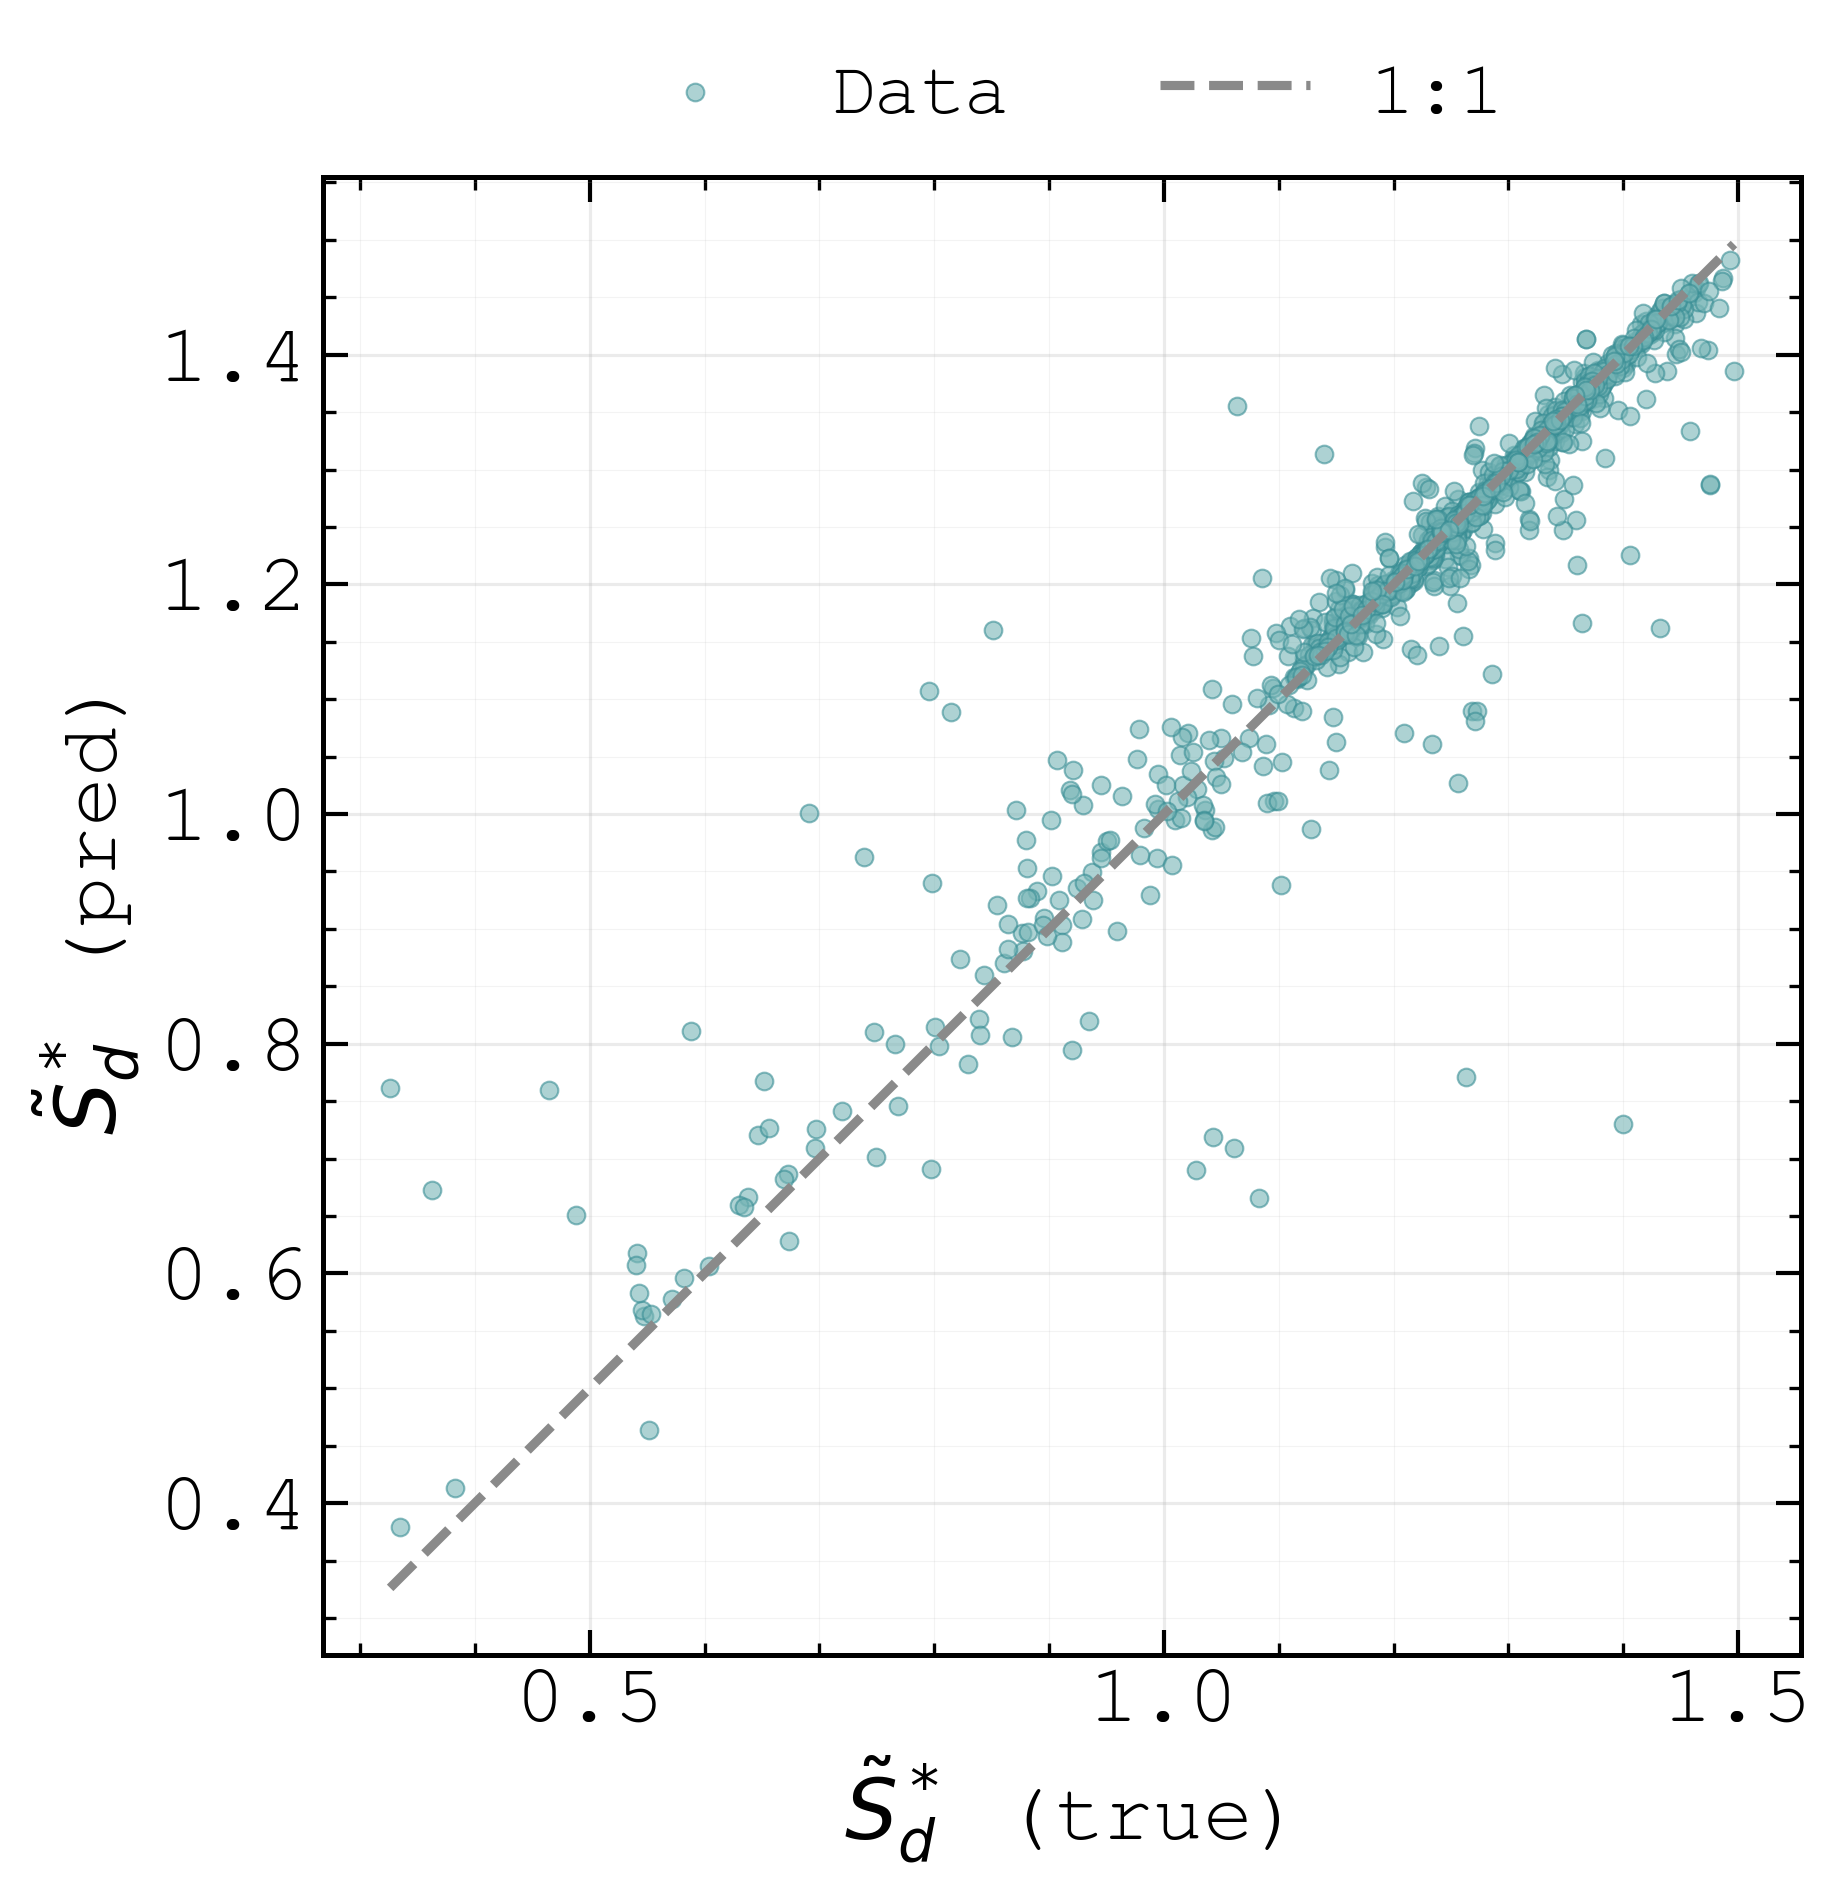

JMI top-4: ['vorticity', 'dTdx', 'u_n', 'du_ndx']
JMI RMSE: 4.794548e-02


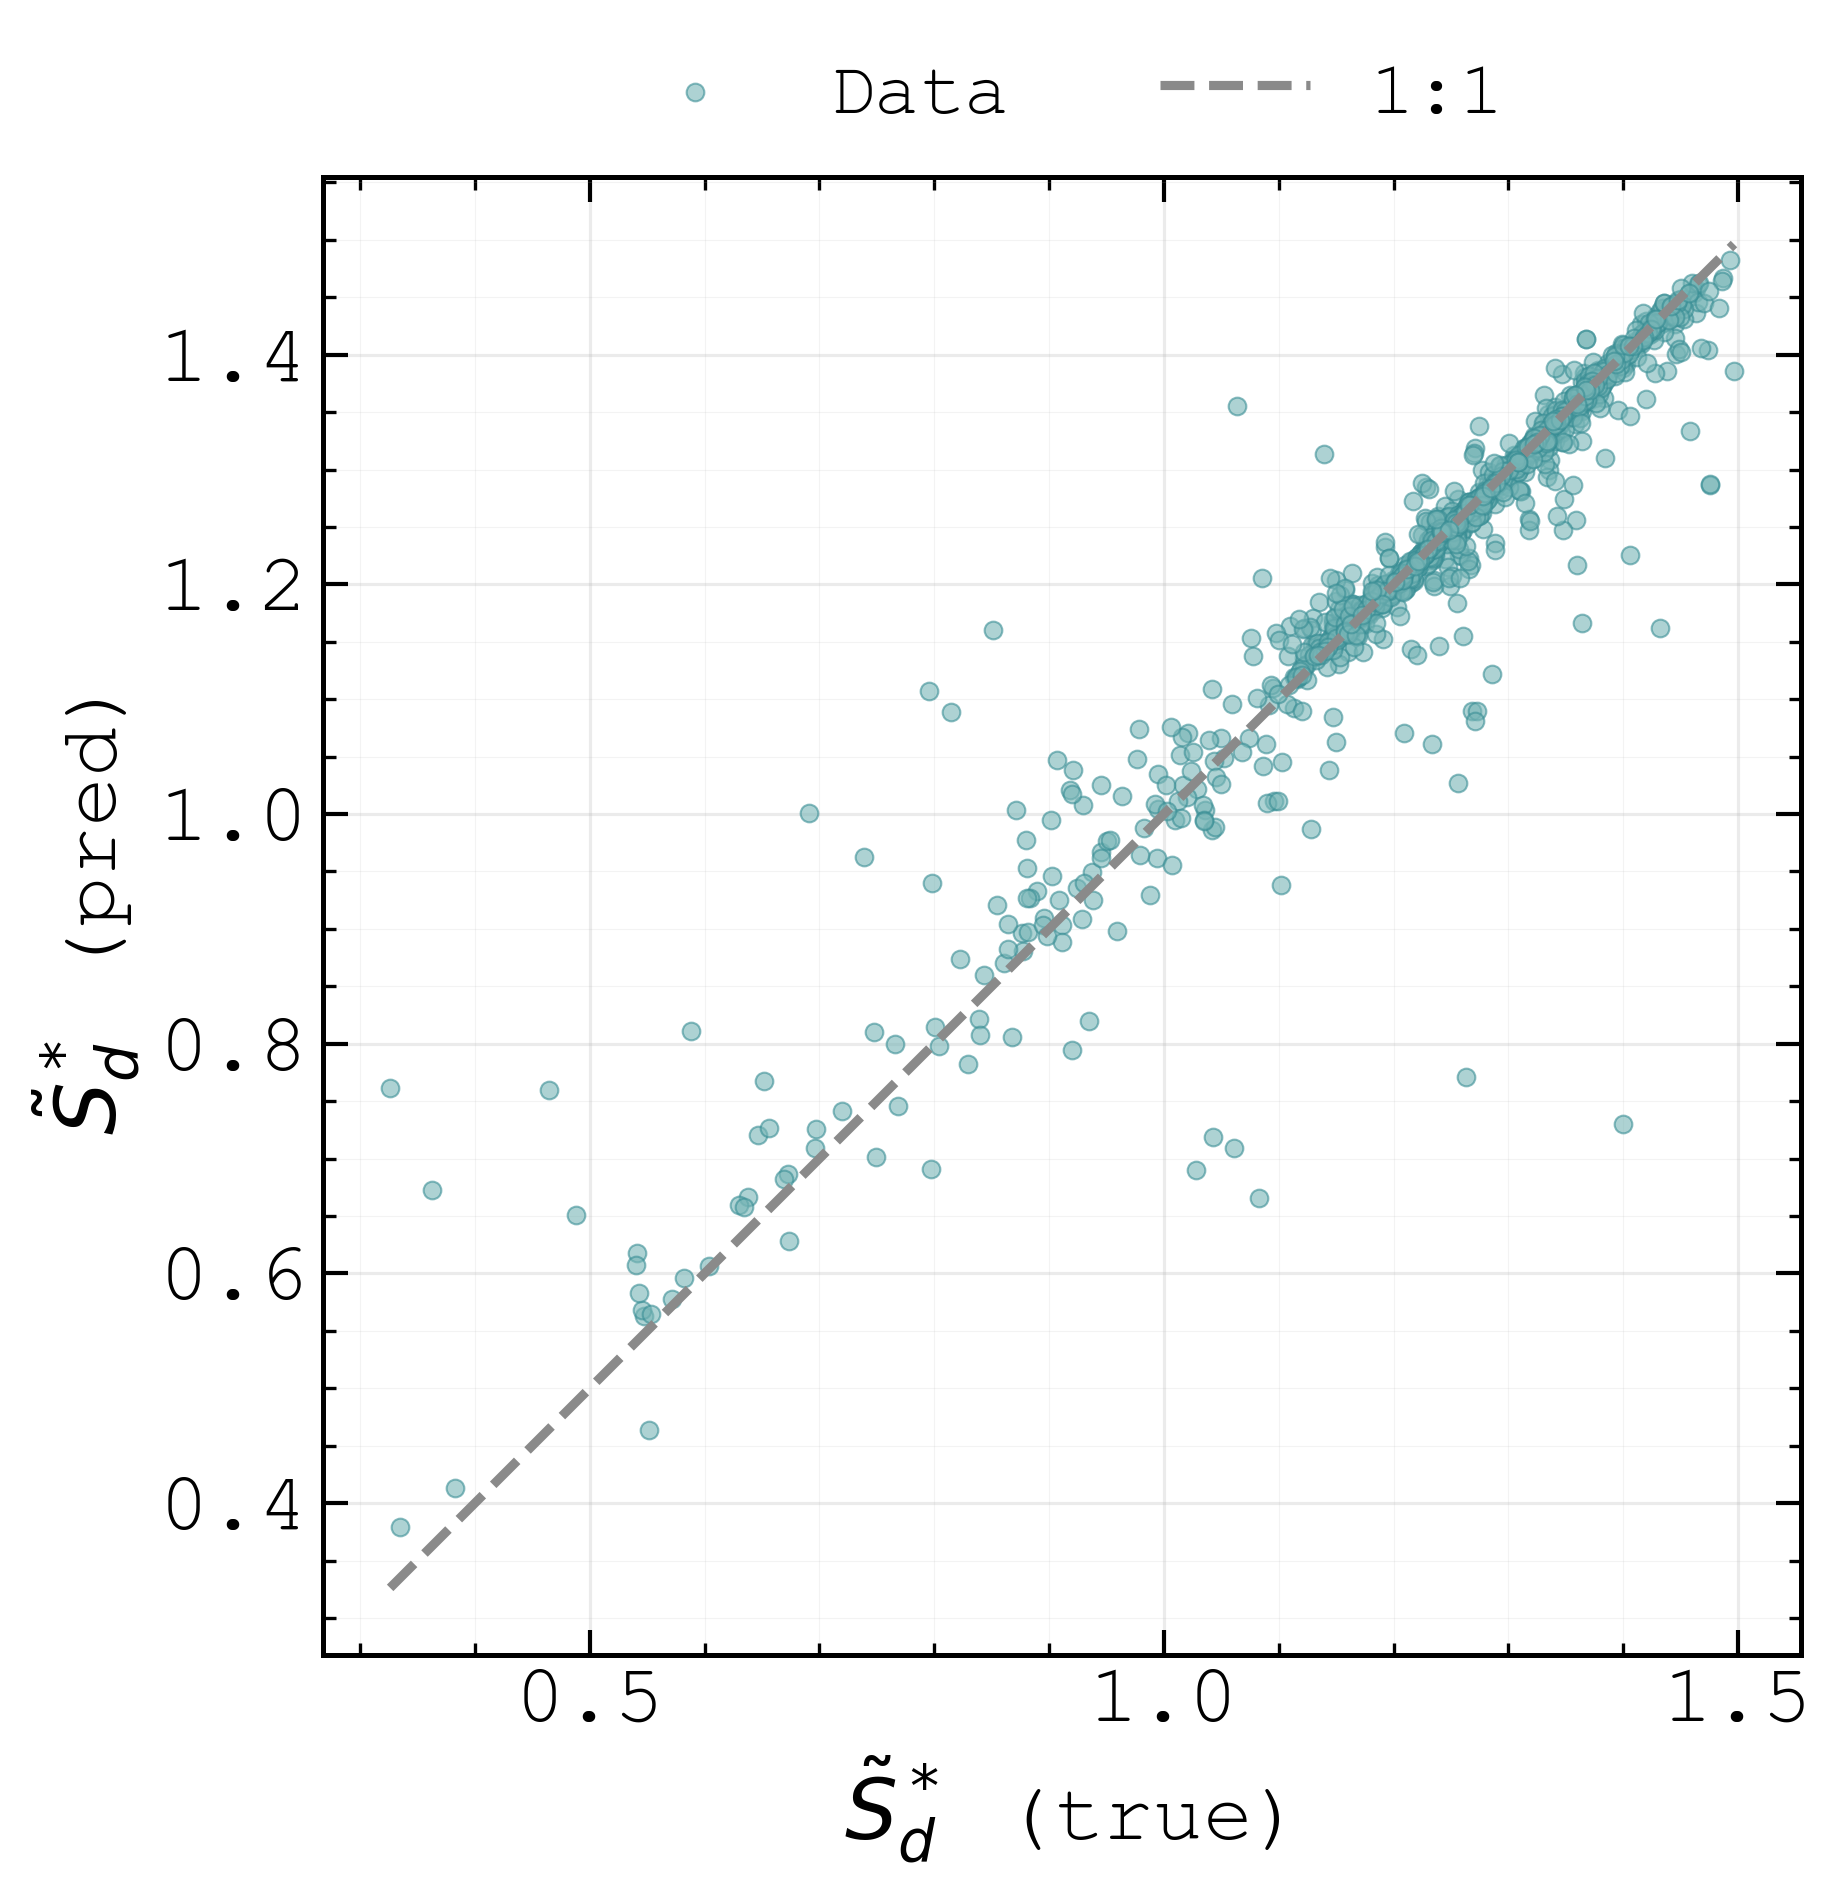

CMIM top-4: ['vorticity', 'dTdx', 'u_n', 'du_ndx']
CMIM RMSE: 4.794548e-02

--- Cluster 2 (eval) | n=9433 ---


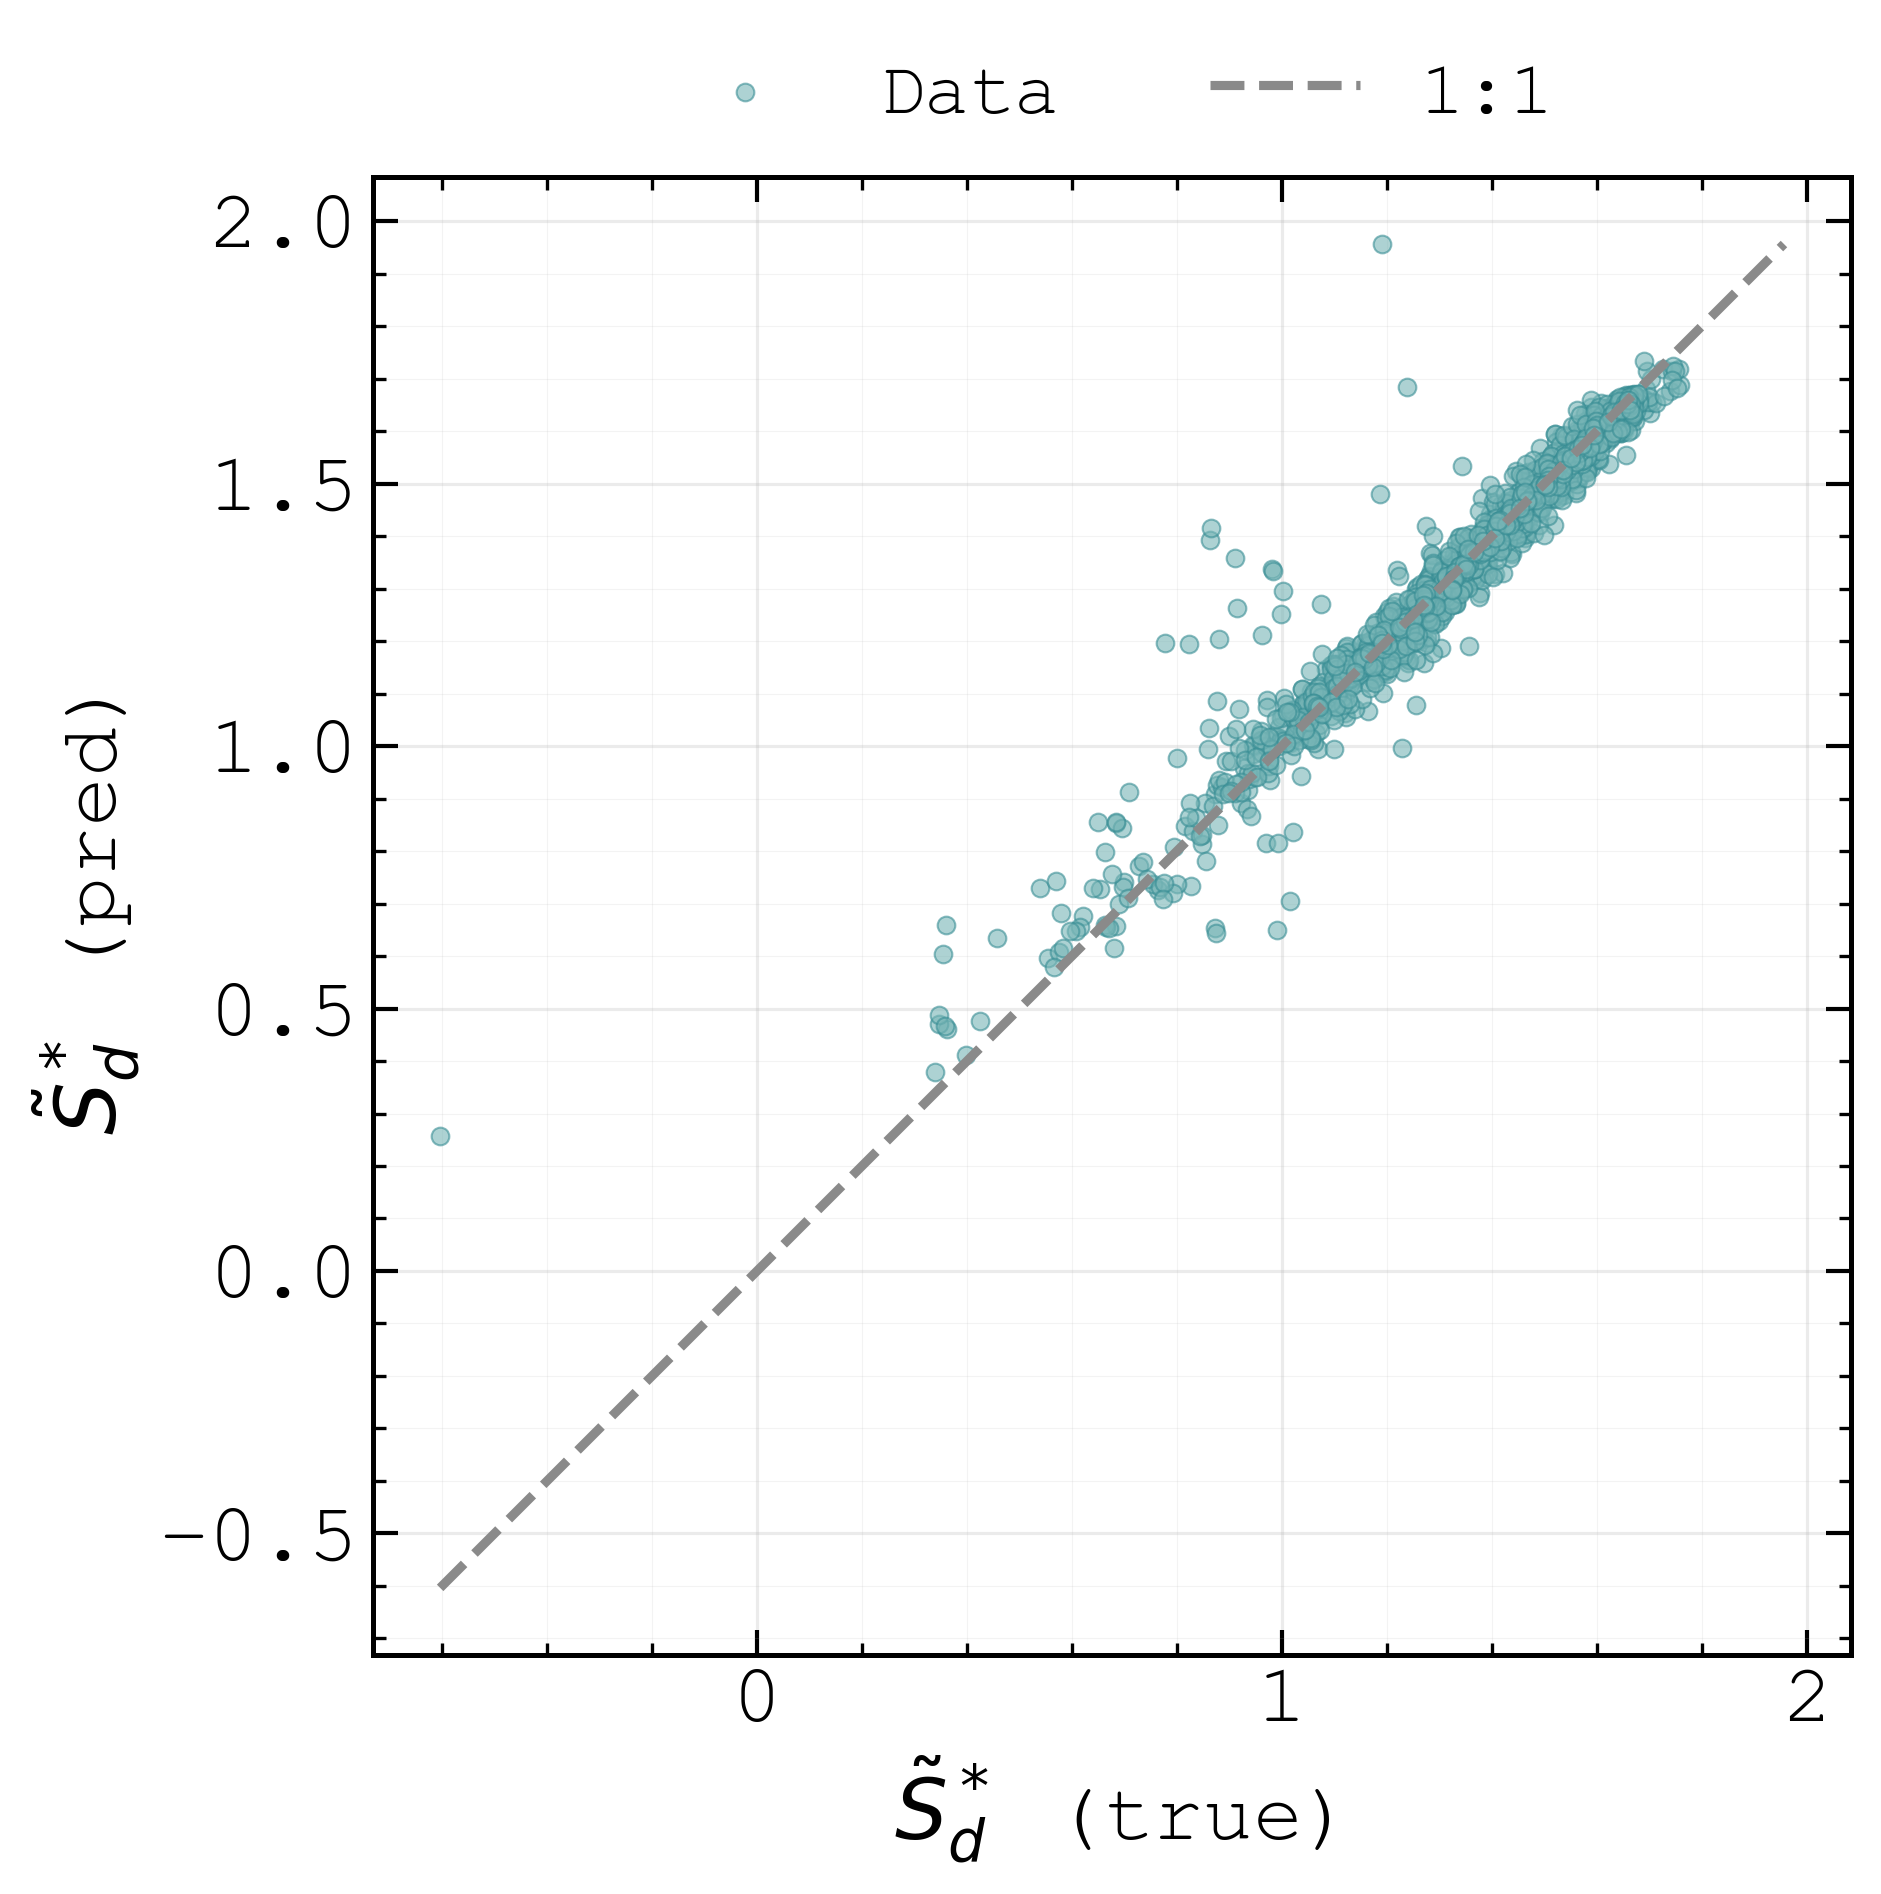

JMI top-4: ['du_ndy', 'du_ndx', 'dTdy', 'dTdx']
JMI RMSE: 5.230683e-02


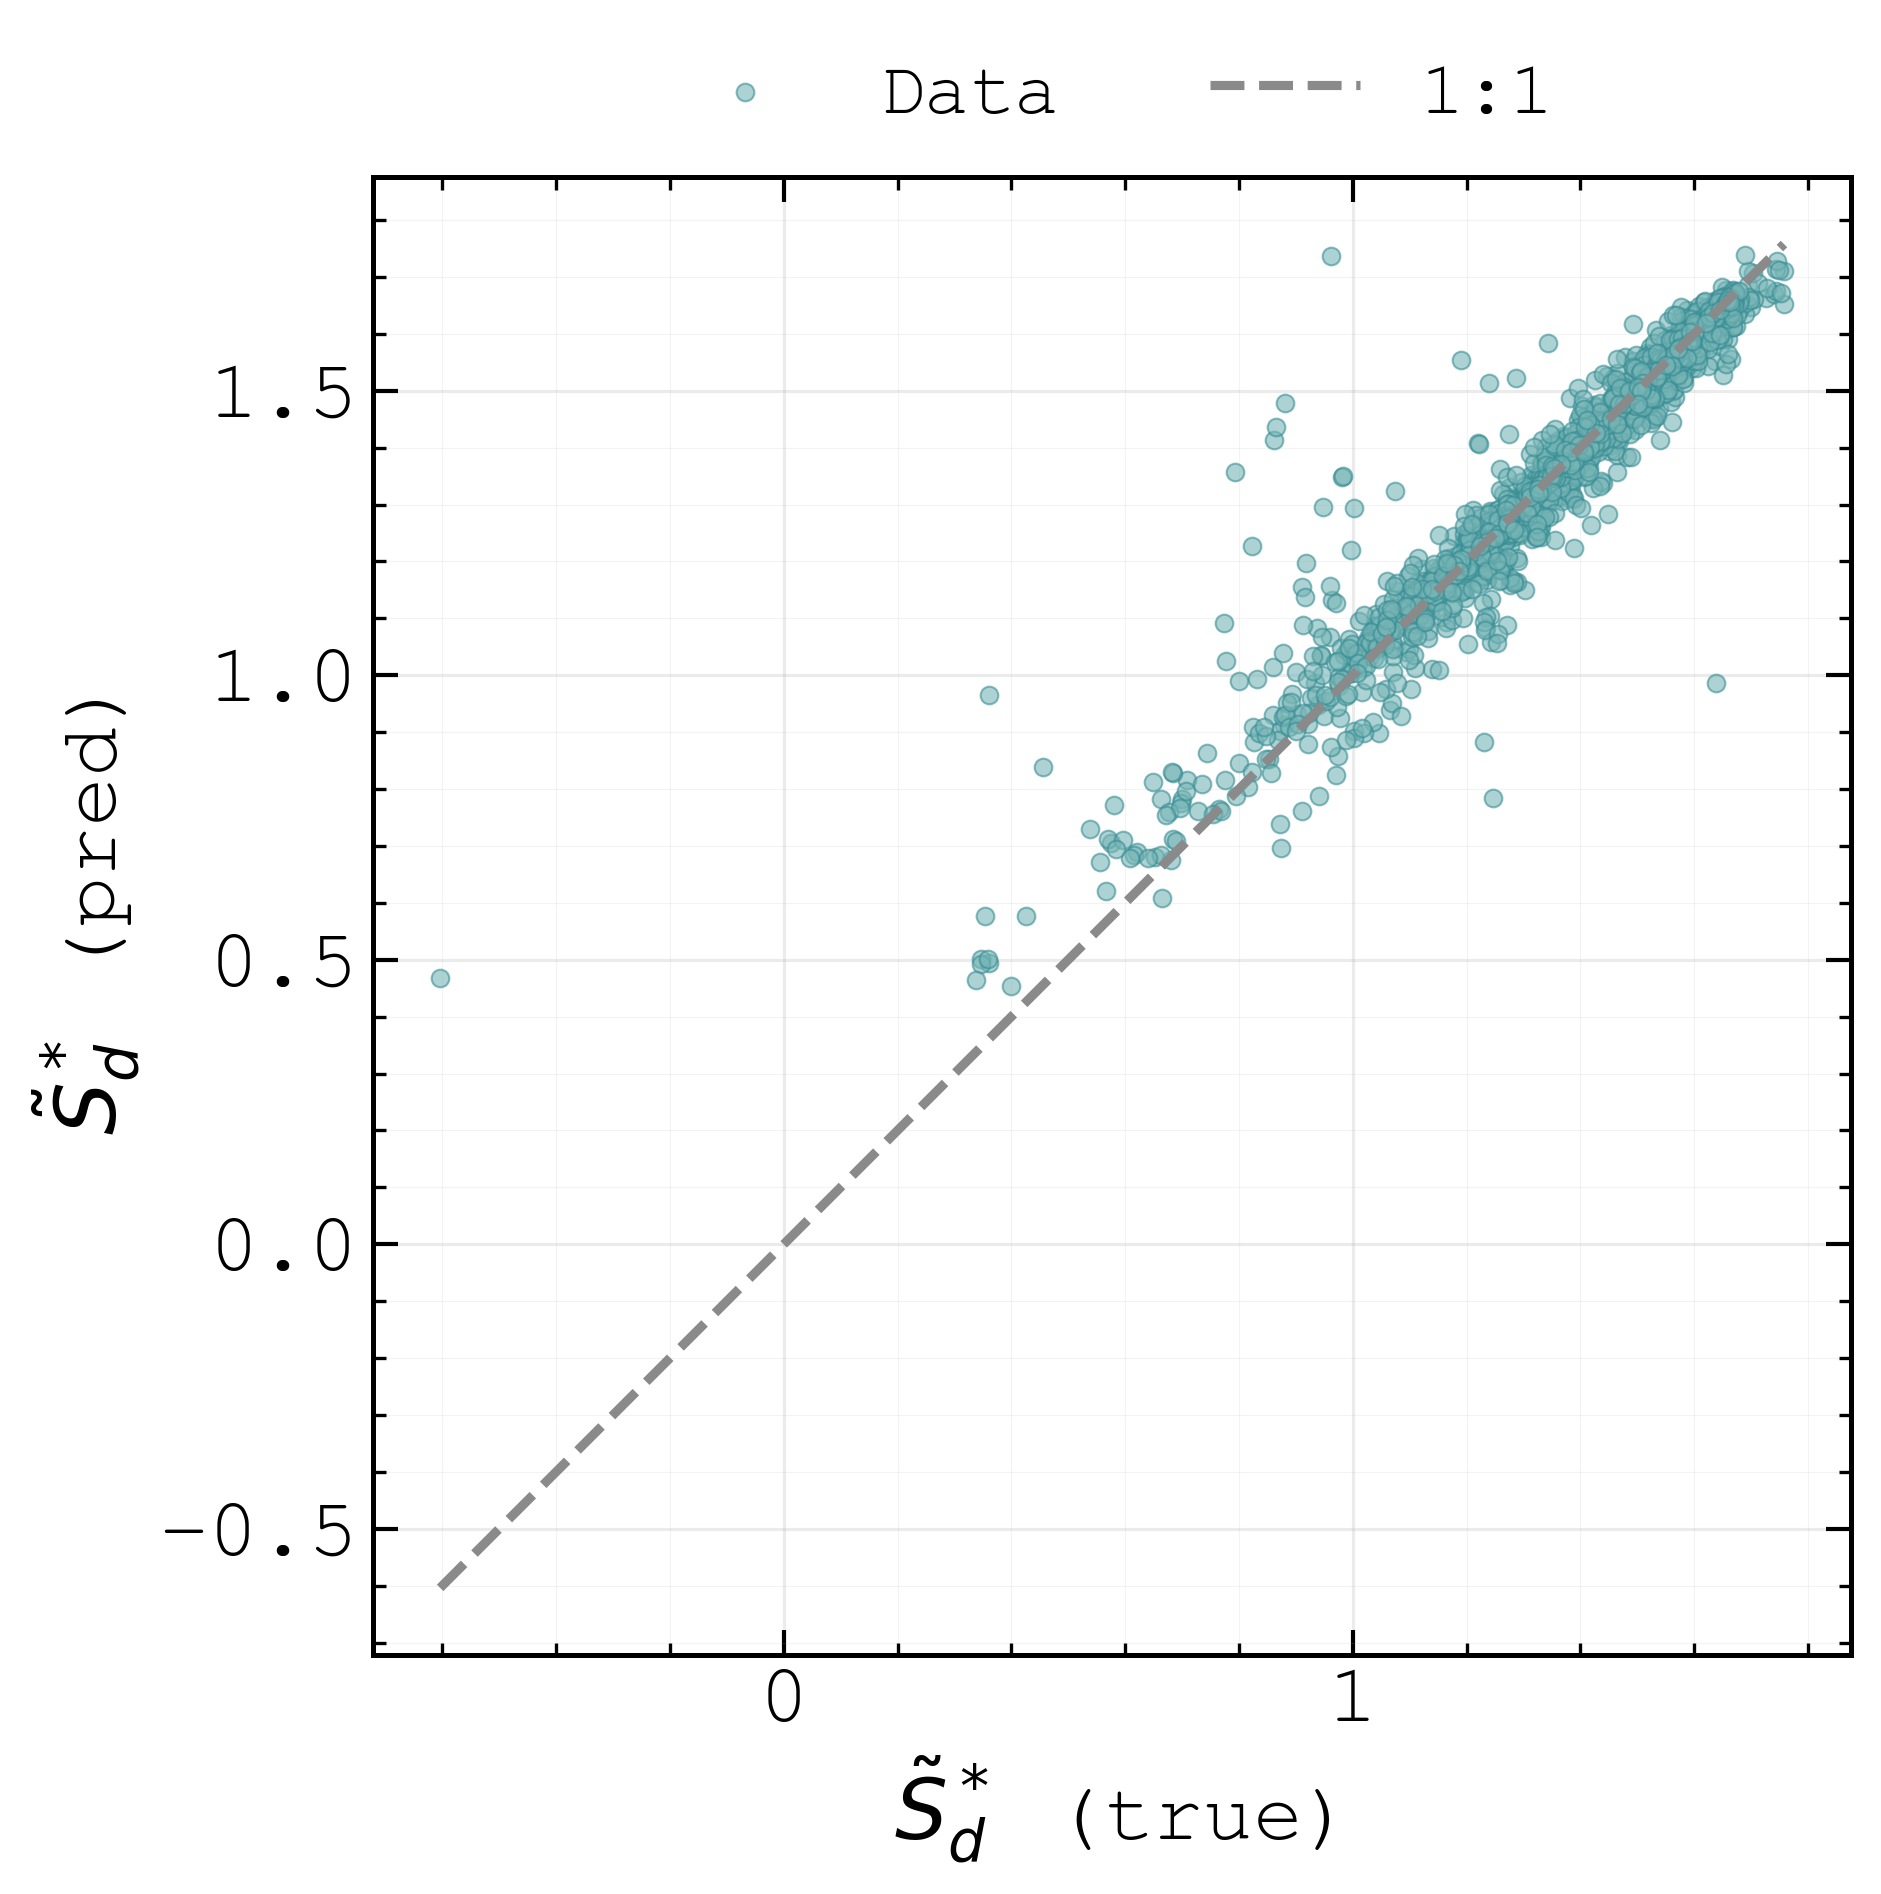

CMIM top-4: ['du_ndy', 'du_ndx', 'dTdx', 'u_n']
CMIM RMSE: 6.324955e-02

Per-cluster RF RMSE (JMI vs CMIM):
 cluster method  n_cluster  n_features     rmse
       0    JMI       3109           4 0.186871
       0   CMIM       3109           4 0.163384
       1    JMI       5985           4 0.047945
       1   CMIM       5985           4 0.047945
       2    JMI       9433           4 0.052307
       2   CMIM       9433           4 0.063250

[INFO] Wrote metrics: /media/alexandros/OS/Users/alexp/Documents/Bachelor Thesis/Code/report_figures/results/mi_cluster_jmi_cmim/lat_200/t_200_to_220/h_200_t_200_210_220_iso_0.6/jmi_cmim_rf_metrics.csv


In [8]:
# === Evaluate JMI vs CMIM with RF (per curvature cluster) ===

if "jmi_df" not in locals():
    jmi_path = SAVE_DIR / "jmi_selected_features.csv"
    jmi_df = pd.read_csv(jmi_path) if jmi_path.exists() else pd.DataFrame()

if "cmim_df" not in locals():
    cmim_path = SAVE_DIR / "cmim_selected_features.csv"
    cmim_df = pd.read_csv(cmim_path) if cmim_path.exists() else pd.DataFrame()

if jmi_df.empty and cmim_df.empty:
    print("[WARN] No JMI/CMIM selection results found; run selection first.")
else:
    eval_rows: List[dict] = []

    for cl in range(N_CLUSTERS):
        sub = dfc[dfc["cluster"] == cl].copy()
        n_cl = len(sub)
        print(f"\n--- Cluster {cl} (eval) | n={n_cl} ---")

        if n_cl < MIN_CLUSTER_SAMPLES:
            print(f"Skipping (n < MIN_CLUSTER_SAMPLES={MIN_CLUSTER_SAMPLES})")
            continue

        sub = sub.dropna(subset=rep_features + [TARGET_VAR])
        if len(sub) < MIN_CLUSTER_SAMPLES:
            print(f"Skipping after dropna (n < MIN_CLUSTER_SAMPLES={MIN_CLUSTER_SAMPLES})")
            continue

        for method, df_sel in [("JMI", jmi_df), ("CMIM", cmim_df)]:
            if df_sel.empty:
                continue

            feats = (
                df_sel[df_sel["cluster"] == cl]
                .sort_values("rank")
                .head(TOPK_REP_PRED)["feature"]
                .tolist()
            )

            if len(feats) == 0:
                print(f"{method}: no features for cluster {cl}; skipping.")
                continue

            X = sub[feats].to_numpy()
            y = sub[TARGET_VAR].to_numpy()

            Xtr, Xte, ytr, yte = train_test_split(
                X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
            )
            model = RandomForestRegressor(**MODEL_PARAMS)
            model.fit(Xtr, ytr)

            ypred = model.predict(Xte)
            rmse = float(np.sqrt(mean_squared_error(yte, ypred)))

            plot_pred_vs_true(
                yte,
                ypred,
                title=f"{method} Cluster {cl}",
                save_stem=f"pred_vs_true_{method.lower()}_cluster_{cl}_top{len(feats)}",
            )

            eval_rows.append({
                "cluster": cl,
                "method": method,
                "n_cluster": int(n_cl),
                "n_features": int(len(feats)),
                "rmse": rmse,
            })

            print(f"{method} top-{len(feats)}: {feats}")
            print(f"{method} RMSE: {rmse:.6e}")
    if eval_rows:
        eval_df = pd.DataFrame(eval_rows)
        eval_csv = SAVE_DIR / "jmi_cmim_rf_metrics.csv"
        eval_df.to_csv(eval_csv, index=False)
        print("\nPer-cluster RF RMSE (JMI vs CMIM):")
        print(eval_df.to_string(index=False))
        print(f"\n[INFO] Wrote metrics: {eval_csv}")
    else:
        print("\nNo clusters met MIN_CLUSTER_SAMPLES; no RF metrics to report.")
